In [1]:
import os
import pymysql
from ast import literal_eval
import matplotlib.pyplot as plt
import time
import datetime as dt
from datetime import timedelta 
import numpy as np
import pandas as pd
import pytz
from datetime import timezone
import sys
import matplotlib
import itertools
from matplotlib.lines import Line2D
pd.set_option('display.max_rows', 9999)
%matplotlib notebook

Login creditials to access the database created through import the dump file AHF2019-Females.sql
Please fill in the credentials as instructed

In [2]:
'''
Fill in the defaultHost, User, Database, password if db is on another computer
No need to fill in if only the local computer is used
'''
defaultHost = "**********"
# user credentials to access the db
defaultUser = "***********"
defaultDatabase = "***********"
defaultPassword = "***********"
'''
credentials to access database located on local computer (computer running this script)
fill in the localhost, user, database, password accordngly
localHost should be 'localhost' if the database is on the same computer
'''
localHost = 'localhost'
#user creditials to access the db
localUser = '***********'
# Change localDatabase variable if the databse is renamed
localPassword = '*********'
localDatabase = '*********'

In [3]:
#Basic Query fucntion used in other functions
def columnQuery(cur, mousetag, column, value):
    '''
    Takes as parameters: int mousetag and str coloumn where mousetag is the rfid number of the mouse and column is a coloumn in the relational database.
    returns a list containing all values from 'coloumn' associated with that mouse.
    '''
    query_config = """SELECT * FROM `raw_data`  WHERE `Tag` = %s AND `{column}` = %s ORDER BY `Timestamp`""".format(column=column)
    cur.execute(query_config, [mousetag, value])
    return cur.fetchall()

In [4]:
'''
Get cursor for local or remote db
For the all of the following analysis the local data base is used
If needed to query remote db, change the getFromDatabase('local') in all lines to getFromDatabase('remote')
'''
def getFromDatabase(machine):
        cur= None 
        if machine == 'local':
            try:
                db_local = pymysql.connect(host=localHost, user=localUser, db=localDatabase, password=localPassword)
                cur=db_local.cursor()
                print("Succesfully conected to local database using default credentials")
            except:
                print("Please check local database credentials, no connection was established using default credentials")
            finally:
                return cur
        elif machine == 'remote':
            try:
                db_remote = pymysql.connect(host=defaultHost, user=defaultUser, db=defaultDatabase, password=defaultPassword)
                cur = db_remote.cursor()
                print("Succesfully conected to remote database using default credentials")
            except:
                print("Please check remote database credentials, no connection was established using default credentials")
            finally:
                return cur

In [5]:
'''
query for n event of a single mice from a certain cage
returns df with n events per day
'''
def db_event_query_mouse(event,cage,tag):
    cur=getFromDatabase('local')
    if event=='Fix':
        query = """SELECT `Tag`,`Timestamp`,`Event` FROM `raw_data` WHERE `Event`= %s AND `Cage` =%s AND `Event_dict`="{'result': 'check+'}" AND `Tag` =%s """
    else:
        query="""SELECT `Tag`,`Timestamp`,`Event` FROM `raw_data` WHERE `Event`= %s AND `Cage` =%s AND `Tag` =%s """
    columns=['Tag','Timestamp','Event']
    cur.execute(query, [event,cage,tag])
    df=pd.DataFrame(data=cur.fetchall(),columns=columns)
    if len(df)==0:
        print(f'No event detected for str{tag}')
    df=df.groupby(pd.Grouper(key='Timestamp',freq='D')).count()
    df.drop('Tag',axis=1)
    df.Tag=tag
    df=df.rename(columns={'Event':event+'_Daily'})
    return df

In [6]:
"""
HeadFix Time query
"""
def db_event_query_mouse2(tag,cage,FixStartDay=None):
    cur=getFromDatabase('local')
    query = """SELECT `Tag`,`Timestamp`,`Event`,`Event_dict` FROM `raw_data` WHERE `Cage` =%s  AND `Tag` =%s """
    cur.execute(query, [cage,tag])
    columns=['Tag','Timestamp','Event','Event_dict']
    df=pd.DataFrame(data=cur.fetchall(),columns=columns)
    return df

In [7]:
'''
generates a date from user input
usful in later functions 
'''
def date_range():
    date_start=input('Enter start date to look at (YYYY-MM-DD):')
    date_end=input('Enter end date to look at(YYYY-MM-DD):')
    sdate = dt.datetime.strptime(date_start, '%Y-%m-%d').date()
    edate = dt.datetime.strptime(date_end, '%Y-%m-%d').date()
    delta = edate - sdate       # as timedelta
    date_range=[]
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        date_range.append(day.strftime('%Y-%m-%d'))
    return date_range

In [8]:
'''
returns n event of a all mice from a certain cage
returns df with n events per day
plots the graph of event per day
makes use of the fucntion db_event_query_mouse
Fix start_day: day when head fixing started(lose-fix)
'''
def db_event_query_mice(tags,cage,event,Fix_startday=None):
    listdf=[]
    listcmap=[]
    for i in tags:
        listdf.append(db_event_query_mouse(event,cage,i))
    df_concat=pd.concat(listdf)
    #ploting for each individual mice
    #df2.groupby('Tag').plot(kind='bar',x='Timestamp',y=event+'_Daily')
    df_concat=df_concat.reset_index()
    if Fix_startday is not None:
        df_concat=df_concat.loc[df_concat.Timestamp>=Fix_startday]
    else:
        pass
    df_pivot=df_concat.pivot(index='Timestamp',columns='Tag',values=event+'_Daily')
    df_pivot=df_pivot.reset_index()
    ax=df_pivot.loc[:,tags].plot.bar(stacked=True, figsize=(11,13))
    ax.set_ylabel(event[0].upper()+event[1:]+'/Day',size=24,labelpad=10)
    ax.set_xlabel('Days Relative to HeadFix Start',size=24,labelpad=10)
    n=10
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::n])
    ax.xaxis.set_ticklabels(ticklabels[::n],rotation=360) 
    ax.set_title(cage[0].upper()+cage[1:] +' Total '+event[0].upper()+event[1:],size=27,pad=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.savefig(cage[0].upper()+cage[1:] +'_Total_'+event[0].upper()+event[1:]+'.svg')
    return df_concat

In [9]:
'''
query for headfixer settings of a single cage in local db
Since all mouse are set at the same levels, tag 2018121244 are used to get all the settings
plots the graphs of headfix time and propheadfix time
returns df containing of timestamp, propheadfix, and headfix time.
'''
def db_headfixer_config(cage):
    cur=getFromDatabase('local')
    query = """SELECT * FROM `raw_data` WHERE `Event` = 'config_HeadFixer' AND `cage` = %s AND `Tag` ='2018121244' """
    columns=['ID','Tag','Event','Event_dict','Timestamp','Cage','position']
    cur.execute(query, [cage])
    df=pd.DataFrame(data=cur.fetchall(),columns=columns)
    df['Timestamp']=df['Timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))
    df=df.reset_index()
    df=df.drop('index',axis=1)
    headfixtime=[]
    for i in df.Event_dict:
        headfixtime.append(eval(i)['headFixTime'])
    propHeadFix=[]
    for i in df.Event_dict:
        try:
            propHeadFix.append(eval(i)['propHeadFix'])
        except Exception:
            propHeadFix.append(np.nan)
    df['HeadFixTime']=headfixtime
    df['PropHeadFix']=propHeadFix
    df=df.drop_duplicates('Timestamp')
    df=df.set_index('Timestamp')
    df=df[['HeadFixTime','PropHeadFix']]
    df.index=pd.to_datetime(df.index)
    df=df.resample('D').mean()
    '''
    1.Settings are only logged when the homecage system turns on
    if it is left on for days, the settings are only logged on the first day.
    Days with nan are replaced with the previous day's settings
    2. Whenever settings are changed, the homecage system needs to be restarted
    and hence the settings will be logged in
    '''
    for i in range(len(df['HeadFixTime'])):
        if np.isnan(df['HeadFixTime'].iloc[i]):
            df['HeadFixTime'].iloc[i]=df['HeadFixTime'].iloc[i-1]
        else:
            pass
    for i in range(len(df['PropHeadFix'])):
        if np.isnan(df['PropHeadFix'].iloc[i]):
            if i!=0:
                df['PropHeadFix'].iloc[i]=df['PropHeadFix'].iloc[i-1]
            else:
                df['PropHeadFix'].iloc[i]=0
        else:
            pass
    list_days=[]
    for i in range(len(df.index)):
        list_days.append(i+1)
    df['Exp_Day']=list_days
    fig=plt.figure()
    plt.plot(df.Exp_Day,df.PropHeadFix, color='green')
    plt.xlabel('Day')
    plt.legend(['PropHeadFix'])
    plt.ylabel('HeadFix Probability / Entry')
    plt.title('Changes in HeadFixer Settings',y=1.07)
    fig2=plt.figure()
    plt.plot(df.Exp_Day,df.HeadFixTime, color='red')
    #plt.xticks(rotation=60)
    #plt.xticks(np.arange(0, 45, step=5))
    plt.xlabel('Day')
    plt.ylabel('HeadFix Time Per Session (Seconds)')
    plt.legend(['HeadFix Time'])
    plt.title('Changes in HeadFixer Settings',y=1.07)
    plt.tight_layout()
    return df

In [10]:
'''
query for Stimulator settings of a single cage in local or remote db
Since all mouse have the same configuration levels, tag 2018121244 are used to get all the settings
plots the graph containning lickwithold_time, mouse_level, and delay time against Timestamp
returns df containing of timestamp, propheadfix, and headfix time.
'''
def db_Stimulator_config(cage):
    cur_local=getFromDatabase('local')
    query = """SELECT * FROM `raw_data` WHERE `Event` = 'config_Stimulator' AND `cage` = %s AND `Tag` ='2018121244' """
    cur_local.execute(query, [cage])
    columns=['ID','Tag','Event','Event_dict','Timestamp','Cage','position']
    df=pd.DataFrame(data=cur_local.fetchall(),columns=columns)
    delayTime= []
    for i in df.Event_dict:
        delayTime.append(eval(i)['delayTime'])
    df['delayTime']=delayTime
    Mouse_level=[]
    for i in df.Event_dict:
       Mouse_level.append(eval(i)['mouseLevel'])
    df['Mouse_level']=Mouse_level
    lickwithhold=[]
    for i in df.Event_dict:
        lickwithhold.append(eval(i)['lickWithholdTime'])
    delayTime=[]
    for i in df.Event_dict:
        delayTime.append(eval(i)['delayTime'])
    df['lickwitholdtime']= lickwithhold
    df['Timestamp']=df['Timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))
    df=df.drop_duplicates('Timestamp')
    df=df.set_index('Timestamp')
    df=df[['Mouse_level','delayTime','lickwitholdtime']]
    df.index=pd.to_datetime(df.index)
    df=df.resample('D').mean()
    '''
    1.Settings are only logged when the homecage system turns on
    if it is left on for days, the settings are only logged on the first day.
    days with nan are replaced witht the previous day's settings
    2. Whenever settings are changed, the homecage system needs to be restarted
    and hence the settings will be logged in
    '''
    for i in range(len(df['Mouse_level'])):
        if np.isnan(df['Mouse_level'].iloc[i]):
            df['Mouse_level'].iloc[i]=df['Mouse_level'].iloc[i-1]
        else:
            pass
    for i in range(len(df['delayTime'])):
        if np.isnan(df['delayTime'].iloc[i]):
            if i!=0:
                df['delayTime'].iloc[i]=df['delayTime'].iloc[i-1]
            else:
                df['delayTime'].iloc[i]=0
        else:
            pass
    for i in range(len(df['lickwitholdtime'])):
        if np.isnan(df['lickwitholdtime'].iloc[i]):
            if i!=0:
                df['lickwitholdtime'].iloc[i]=df['lickwitholdtime'].iloc[i-1]
            else:
                df['lickwitholdtime'].iloc[i]=0
        else:
            pass
    list_days=[]
    for i in range(len(df.index)):
        list_days.append(i)
    df['Exp_day']=list_days
    fig1=plt.figure()
    plt.plot(df.Exp_day,df.lickwitholdtime, color='red')
    plt.plot(df.Exp_day,df.delayTime,color='blue')
    plt.plot(df.Exp_day,df.Mouse_level,color='orange')
    plt.xticks(rotation=60)
    plt.ylim([-1,4])
    plt.legend(['LickWitholdTime','Delay Time','Mouselevel'])
    plt.title('Changes in Stimulator Settings',y=1.07)  
    return df

In [11]:
'''
to get df in the 2019 AHF format (see coloumns) for a single day of a specific cage from remote db
'''
def db_cage_query_remote(cage,date):
    '''
    returns query of events: lick,entry, exit, Reward, SeshStart, Consumed
    Reward, VideoStart, VideoEnd,BrainLEDOn, BrainLEDOff, Fix, stimulus, outcome
    of a mouse cage on a specific day
    '''
    cur_local=getFromDatabase('remote')
    tomorrow=dt.datetime.strptime(f'{date}', '%Y-%m-%d').date()+ timedelta(days=1)
    columns=['ID','Tag','Event','Event_dict','Timestamp','Cage','position']
    query =  """SELECT * FROM `raw_data` WHERE `cage` = %s AND 
    (`Event`= 'lick' or `Event`='entry' or `Event`='exit' or
    `Event`='Reward'or `Event`='SeshEnd' or
    `Event`= 'SeshStart' or `Event`= 'ConsumedReward' or
    `Event` = 'VideoStart' or `Event` = 'VideoEnd' or `Event` ='BrainLEDON' or `Event` ='BrainLEDOFF' or
    `Event` = 'Fix' or `Event` ='Stimulus' or `Event` ='Outcome')AND
    `Timestamp`< %s AND `Timestamp`> %s ORDER BY `Timestamp` asc"""
    cur_remote.execute(query, [cage,tomorrow,date])
    df=pd.DataFrame(data=cur_remote.fetchall(),columns=columns)
    '''
    Convert time to unix timestamps
    '''
    pst=pytz.timezone('America/Los_Angeles')
    utc= pytz.timezone('Etc/UTC')
    df['unix_time']=df['Timestamp'].apply(lambda x:pst.localize(x))
    df['unix_time']=df['unix_time'].apply(lambda x:x.astimezone(utc) )
    df['unix_time']=df['unix_time'].apply(lambda x:x.replace(tzinfo=None))
    df['unix_time']=df['unix_time'].apply(lambda x:dt.datetime.timestamp(x))
    return df

In [12]:
'''
to get df in dbsql formate (see coloumns) for a single day of a specific cage from local db
'''
def db_cage_query_local(cage,date):
    '''
    returns query of events: lick,entry, exit, Reward, SeshStart, Consumed
    Reward, VideoStart, VideoEnd,BrainLEDOn, BrainLEDOff, Fix, stimulus, outcome
    of a mouse cage on a specific day
    '''
    cur_local=getFromDatabase('local')
    tomorrow=dt.datetime.strptime(f'{date}', '%Y-%m-%d').date()+ timedelta(days=1)
    columns=['ID','Tag','Event','Event_dict','Timestamp','Cage','position']
    query =  """SELECT * FROM `raw_data` WHERE `cage` = %s AND 
    (`Event`= 'lick' or `Event`='entry' or `Event`='exit' or
    `Event`='Reward'or `Event`='SeshEnd' or
    `Event`= 'SeshStart' or `Event`= 'ConsumedReward' or
    `Event` = 'VideoStart' or `Event` = 'VideoEnd' or `Event` ='BrainLEDON' or `Event` ='BrainLEDOFF' or
    `Event` = 'Fix' or `Event` ='Stimulus' or `Event` ='Outcome')AND
    `Timestamp`< %s AND `Timestamp`> %s ORDER BY `Timestamp` asc"""
    cur_local.execute(query, [cage,tomorrow,date])
    df=pd.DataFrame(data=cur_local.fetchall(),columns=columns)
    '''
    Convert time to unix timestamps
    '''
    pst=pytz.timezone('America/Los_Angeles')
    utc= pytz.timezone('Etc/UTC')
    df['unix_time']=df['Timestamp'].apply(lambda x:pst.localize(x))
    df['unix_time']=df['unix_time'].apply(lambda x:x.astimezone(utc) )
    df['unix_time']=df['unix_time'].apply(lambda x:x.replace(tzinfo=None))
    df['unix_time']=df['unix_time'].apply(lambda x:dt.datetime.timestamp(x))
    return df

In [13]:
'''
Small function used in db_To_Textlog to change new 2019 AHF format to old matlab pipline format (<2019) text files
'''
def No_headfix(i):
    if i == "{'result': 'check-'}":
        y="{'result': 'check No Fix Trial'}"
    else:
        y= i
    return y

In [14]:
'''
Get the old textlog format (<2019) of the files for a single day of a specific cage
queries db for data
saves the text file as headFix_{cage}_{date}.txt and returns the df
'''
def db_To_Textlog(cage, date):
    df=db_cage_query_local(cage,date)
    df=df[['Tag','unix_time','Event','Timestamp','Event_dict']]
    df['Timestamp']=df['Timestamp'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
    """
    Rename Fix and reward events
    Fix: check+(fix)/ check No Fix Trial (no Fix)
    Rewrd: Entry reward /Reward
    """
    df['Event_dict']=df['Event_dict'].apply(lambda x: No_headfix(x))
    for i in df.index:
        if df['Event_dict'].iloc[i]=="{'result': 'check+'}":
            df['Event'].iloc[i]= 'check+' 
        elif df['Event_dict'].iloc[i]=="{'result': 'check No Fix Trial'}":
            df['Event'].iloc[i] = 'check No Fix Trial'
        else:
            #df['Event'][i]=df['Event'][i]
            pass  
    '''
    Rename VideoStart to video:+{video name}
    '''
    for i in df.loc[df['Event']=='VideoStart'].index:
            try:
                if df['Event_dict'].iloc[i][:3]=="{'n":
                    df['Event'].iloc[i]='video:'+eval(df['Event_dict'][i])['name']
                else:
                    pass
            except TypeError:
                pass
    '''
    Rename rewards (entry) to entry reward
    '''
    for i in df.loc[df['Event']=='Reward'].index:
        try:
            if eval(df['Event_dict'].iloc[i])['kind'] =='entry':
                df['Event'].iloc[i]='entyReward'
            else: 
                df['Event'].iloc[i]='Reward'
        except Exception:
            pass
    '''
    Edit Outcome event and removing stimulus event
    Currently go vibrator settings:Buzz:N=1.00,length=0.200000,period=0.00,GO=
    '''
    for i, y in zip (df.loc[df['Event']=='Stimulus' ].index,df.loc[df['Event']=='Outcome' ].index):
        df['Event_dict'].iloc[i]=df['Event_dict'].iloc[y] 
        df['Event'].iloc[y]='lickWitholdTime=1.34,Buzz:N=1.00,length=0.200000,period=0.00,GO='+str(eval(df['Event_dict'].iloc[y])['code'])
    df=df.drop(df.loc[df['Event']=='Stimulus'].index)
    for i in df['Tag'].index:
        if len(df['Tag'][i]) ==9:
            df['Tag'][i]='0000'+df['Tag'][i]
        elif len(df['Tag'][i]) ==10:
            df['Tag'][i]='000'+df['Tag'][i]
    df.to_csv(f'headFix_{cage}_{date}.txt', sep='\t', index=False,header=False)
    print(f'{date} Text file created from db')
    return df

In [15]:
'''
Get concanted old version matlab pipline text file over a range of dates
with user input on the specific cage and date range
'''
def Text_log_range():
    cage=input('Cage data to convert to text_log')
    date_range=input('Enter dates to convert to textlog separated by comma')
    date_range=date_range.split(',')
    list_df=[]
    for i in date_range:
        list_df.append(db_To_Textlog(cage,i))
    df = pd.concat(list_df)
    df.to_csv(f'headFix_cagex_{date_range[1]}_{date_range[-1]}.txt', sep='\t', index=False,header=False)
    print(f'{date_range[1]}_{date_range[-1]} Text file created from db')
    return df

In [16]:
'''
Works with new AHF2019 text file formates
Generates dfs for a day of fix sessions of a single cage (curretnly for go session)
Speficially generates:
1.single df of all fix sessions' details of all mice 
2.list of dfs, each containning the raw events of a single head fix session (based on 1)
3. dictionary of df containning fix session details by tag/mouse
Currently removes the fix session if:
1.no or mutiple videostarts/videoends are found Fix{'result': 'check+'} and VideoEnd
2.no Brain LED on/ off were found
'''
def Fix_event(cage,date):
    df_remote=db_cage_query_local(cage,date)
    '''
    Listdf: list of all fix sessions, each fix session is an individual df
    Fix sessions were searched based on the appearance on event_dic(check+ ) and the following VideoEnd
    If no following VideoEnd is detected (for the last headfix/no fix event), it is discarded.
    Discarded sessions are printed in terminal
    '''
    listdf=[]
    for i in df_remote[df_remote['Event_dict']=="{'result': 'check+'}"].index:
        try:
            temp_df=df_remote.iloc[i:]
            first_vidend=temp_df[temp_df['Event']=='VideoEnd'].index[0]
            listdf.append(df_remote.iloc[i:first_vidend+1])
        except Exception as e:
            print(f'No additional VideoEnd found after headfix:check+ {str(i)}')
            print(f'Ignoring all events after {str(i)}')
            pass
        '''
        deleting headfixes with extra video starts
        '''
    list_delete=[]
    for i in range(len(listdf)):
        if 'VideoStart' not in listdf[i].Event.unique():
            print(f'VideoStart event not at {str(i)}')
            list_delete.append(i)
        elif 'BrainLEDON' not in listdf[i].Event.unique():
            print(f'BrainLEDON event not at {str(i)}')
            list_delete.append(i)
        elif 'BrainLEDOFF' not in listdf[i].Event.unique():
            print(f'BrainLEDOFF event not at {str(i)}')
            list_delete.append(i)
        else:
            pass
    list_delete.sort()
    deletion_offset=0
    if len(list_delete) != 0:
        for i in list_delete:
            del listdf[i-deletion_offset]
            deletion_offset+=1
            print(f'HeadFix event number {str(i)} with no VIDEOSTART deleted')
    else:
        print('No extra videostarts detected in all headfix/nofix sessions')
    b=pd.concat(listdf)
    b=b.reset_index()
    b=b.drop('index',axis=1)
    for i in range(len(listdf)):
        listdf[i]=listdf[i].reset_index()
        listdf[i]=listdf[i].drop('index',axis=1)
    '''
    deleting sessions with mutiple videoend or videostart
    '''
    list_delete_2=[]
    for i in range(len(listdf)):
        if (len(listdf[i][listdf[i]['Event']=='VideoEnd'].index) != 1) or (len(listdf[i][listdf[i]['Event']=='VideoStart'].index) != 1):
            print(f'Multiple VideoEnd or VideoStart detected in index: {str(i)}')
            list_delete_2.append(i)
        else:
            pass
    deletion_offset=0
    if len(list_delete_2) != 0:
        for i in list_delete_2:
            del listdf[i-deletion_offset]
            deletion_offset+=1
            print(f'HeadFix event number {str(i)} with Multiple VideoEnd or VideoStart deleted')
    else:
        print('All Headfix sessions have one VideoStart and VideoEnd event')
        pass
    """
    Ilterates through the dataframe list lisftdf creates a new df of all fix session 
    which include Tag,'Tag','Session_Start_Time',
    'Session_Duration(s)','number of Trials','Trial_outcomes','Trial_start time','Video_name',
    'Start time of each trial (unix)', BrainLED on & BrainLED off time, timestamps where licking occur,
    lick rates for each fix session
    """
    list_session_dur=[]
    list_num_trial=[]
    list_outcomes=[]
    list_outcome_unixtime=[]
    list_session_start_time=[]
    list_tag=[]
    list_vid=[]
    list_stimulus_time=[]
    BrainLED_ontime=[]
    BrainLED_offtime=[]
    Reward_unix_timestamps=[]
    lick_times_df=[]
    lick_times_rate=[]
    for i in range(len(listdf)):
        '''
        appends all events of interest to the empyt list created and then concates the lists to a dataframe
        '''
        index_vidend=listdf[i][listdf[i]['Event']=='VideoEnd'].index[0]
        index_vidstart=listdf[i][listdf[i]['Event']=='VideoStart'].index[0]
        Session_dur=listdf[i].iloc[index_vidend]['unix_time']-listdf[i].iloc[index_vidstart]['unix_time']
        num_trial=len(listdf[i][listdf[i]['Event']== 'Outcome'])
        VidStart_loc=listdf[i][listdf[i]['Event']=='VideoStart'].index[0]
        list_vid.append(eval(listdf[i].iloc[VidStart_loc]['Event_dict'])['name'])
        brain_LEDON_index=listdf[i][listdf[i].Event=='BrainLEDON'].index[0]
        brain_LEDOFF_index=listdf[i][listdf[i].Event=='BrainLEDOFF'].index[0]
        outcome_codes=[]
        outcome_codes_unix_time=[]
        stimlus_time=[]
        reward_index=[]
        Reward_unix_time=[]
        lick_times=[]
        lick_rates=[]
        for y in listdf[i][listdf[i]['Event']== 'Reward'].index:
            reward_index.append(y)
        if len(reward_index) != 0:
            for z in reward_index:
                Reward_unix_time.append(listdf[i].iloc[z]['unix_time'])
        else:
            pass
        for y in listdf[i].Event_dict:
            try:
                outcome_codes.append(eval(y)['code'])
            except Exception:
                pass
        for y in listdf[i][listdf[i]['Event']== 'Outcome'].index:
            outcome_codes_unix_time.append(listdf[i].iloc[y]['unix_time'])
        for y in listdf[i][listdf[i]['Event']== 'Stimulus'].index:
            stimlus_time.append(listdf[i].iloc[y]['unix_time'])
        for y in listdf[i][listdf[i].Event=='lick'].unix_time:
            lick_times.append(y)
        for y in 60/listdf[i][listdf[i].Event=='lick'].unix_time.diff(1):
            lick_rates.append(y)
        BrainLED_ontime.append(listdf[i].iloc[brain_LEDON_index]['unix_time'])
        BrainLED_offtime.append(listdf[i].iloc[brain_LEDOFF_index]['unix_time'])
        list_session_dur.append(Session_dur)
        list_num_trial.append(num_trial)
        list_outcomes.append(outcome_codes)
        list_session_start_time.append(listdf[i].iloc[index_vidstart]['Timestamp'])
        list_outcome_unixtime.append(outcome_codes_unix_time)
        list_stimulus_time.append(stimlus_time)
        # just used index 2 to get tag, assuming all tags in a headfix session is the same
        list_tag.append(listdf[i].iloc[2]['Tag'])
        lick_times_df.append(lick_times)
        lick_times_rate.append(lick_rates)
        Reward_unix_timestamps.append(Reward_unix_time)  
    columns=['Tag','Session_Start_Time','Session_Duration(s)','Number_of_Trials','Trial_outcomes',
             'Video_name','Trial_EndTime','Trial_StartTime','BRAIN_LEDON_TIME','BRAIN_LEDOFF_TIME','Reward_Timestamp',
             'lick_Timestamp','lick_rates']
    data=list(zip(list_tag,list_session_start_time, list_session_dur,list_num_trial,list_outcomes,list_vid,
                  list_outcome_unixtime,list_stimulus_time,BrainLED_ontime,BrainLED_offtime,Reward_unix_timestamps,
                  lick_times_df,lick_times_rate))
    df=pd.DataFrame(data=data,columns=columns)
    """
    Some Additonal measurements including n rewards given during the session
    percent sucess for that session
    other outcomes can also be added here
    """
    df['Fix_type']='Fix'
    df['N_Reward_Given']=df.apply(lambda x: len(x['Reward_Timestamp']),axis=1)
    df['Percent_Sucess']=df['N_Reward_Given']/df['Number_of_Trials']*100
    """
    creates a dictionary holding the details of the fix session dfs sorted by mice/tag
    """
    dfs_byTag = [g for _, g in df.groupby('Tag')]
    Dicdf_by_tag={}
    for i in dfs_byTag:
        Dicdf_by_tag[i.iloc[0]['Tag']]=i
    print(f'{date} Headfix Session df created')
    '''
    returns 
    df:a dataframe of headfixing events with all associated variables,
    listdf:a list of df containning each individual headfixing event,
    Dicdf_by_tag: a dictionary conatining the dfs by tag
    '''
    return df,listdf,Dicdf_by_tag

In [17]:
'''
Get a range of Head fix sessions from day using Fix_event(cage,date)
'''
def Head_fix_range():
    cage=input('Cage data to convert to text_log')
    date_start=input('Enter start date to look at (YYYY-MM-DD):')
    date_end=input('Enter end date to look at(YYYY-MM-DD):')
    sdate = dt.datetime.strptime(date_start, '%Y-%m-%d').date()
    edate = dt.datetime.strptime(date_end, '%Y-%m-%d').date()
    delta = edate - sdate 
    date_range=[]
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        date_range.append(day.strftime('%Y-%m-%d'))
    list_df=[]
    for i in date_range:
        _,_,df_bydic=Fix_event(cage,i)
        list_df.append(df_bydic)
    print('All processes completed')
    return list_df

In [18]:
'''
Get a range of Head fix sessions from day using Fix_event(cage,date)
'''
def Head_fix_range_time():
    cage=input('Cage data to convert to text_log')
    date_start=input('Enter start date to look at (YYYY-MM-DD):')
    date_end=input('Enter end date to look at(YYYY-MM-DD):')
    sdate = dt.datetime.strptime(date_start, '%Y-%m-%d').date()
    edate = dt.datetime.strptime(date_end, '%Y-%m-%d').date()
    delta = edate - sdate 
    date_range=[]
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        date_range.append(day.strftime('%Y-%m-%d'))
    list_df=[]
    for i in date_range:
        df,_,_=Fix_event(cage,i)
        list_df.append(df)
    print('All processes completed')
    return list_df

In [19]:
'''
1.Graphs each individual mouse's sucesses rate (per headfix session) and entries per day during go trial
also saves a concatenated version of the df with all fix session detail for the mouse in csv
also saves mean and sem of success rate and daily entry of the mouse in another csv
2.Not used in the final paper and needs some editing to make this fucntion more effecient to apply to other cages
'''
def mouse_fix_stats(Tag,color):
    a=[]
    '''
    some days mice would not have headfixes
    '''
    for i in df_go_trial_HeadFix:
        try:
            a.append(i[Tag])
        except Exception:
            pass  
    '''
    dropping headfix sessions where no trials occured
    '''
    for i in range(len(a)):
        notrial_indices=a[i][a[i].Number_of_Trials==0].index
        if len(notrial_indices) != 0:
            a[i]=a[i].drop(list(notrial_indices))
        else:
            pass
    b=pd.concat(a)
    b=b.reset_index()
    b=b.drop('index',axis=1)
    '''
    saving the csv of session for each animal
    can change name here
    '''
    b.to_csv(f'{Tag}_Head_Fixed_Sessions_2019-10-22_2019-12-02.csv')
    c=b.groupby(pd.Grouper(key='Session_Start_Time', freq='D')).count()
    x_date_range=[dt.date(2019, 10, 22)+ dt.timedelta(days=i) for i in range(len(list_dates_tuple))]
    b=b.set_index('Session_Start_Time')
    b_mean=b.resample('1D').mean()
    b_sem=b.resample('1D').sem()
    b_mean=b_mean[['Session_Duration(s)','Percent_Sucess']]
    b_sem=b_sem[['Session_Duration(s)','Number_of_Trials','N_Reward_Given','Percent_Sucess']]
    b_sem['Entries']=c['Tag']
    list_type=[]
    for i in x_date_range:
        try:
            b_mean.loc[i.strftime('%Y-%m-%d')]
        except Exception:
            list_type.append(i)
    for i in list_type:
        row=pd.Series({'Session_Duration(s)':0,'Number_of_Trials':0,'N_Reward_Given':0,'Percent_Sucess':0},
                      name=i.strftime('%Y-%m-%d %H:%M:%S'))
        b_mean= b_mean.append(row)
        b_sem=b_sem.append(row)
    b_mean=b_mean.reset_index()
    b_mean=b_mean.sort_values(by='Session_Start_Time')
    b_sem=b_sem.reset_index()
    b_sem=b_sem.sort_values(by='Session_Start_Time')
    b_mean.fillna(0, inplace=True)
    b_sem.fillna(0, inplace=True)
    b_mean.fillna(0, inplace=True)
    b_sem.fillna(0, inplace=True)
    x_date_range=[dt.date(2019, 10, 22)+ dt.timedelta(days=i) for i in range(len(list_dates_tuple))]
    list_days=[]
    for i in range(len(b_mean.index)):
        list_days.append(i+1)
    b_mean=b_mean.reset_index()
    b_mean=b_mean.drop('index',axis=1)
    b_sem=b_sem.reset_index()
    b_sem=b_sem.drop('index',axis=1)
    b_mean=b_mean.add_suffix('_Mean')
    b_sem=b_sem.add_suffix('_SEM')
    b_mean['GO_day']=list_days
    b_sem['GO_day']=list_days
    df_day_stats=pd.merge(b_mean,b_sem,on=['GO_day'])
    df_stats=df_day_stats.rename(columns={'Entries_SEM':'Entries'})
    df_stats['Tag']=Tag
    df_stats['Type']='Fix'
    df_stats=df_stats[['Tag','GO_day','Type','Percent_Sucess_Mean','Percent_Sucess_SEM','Entries']]
    df_stats.to_csv(f'{Tag}_HFX_fix_day_stats2019-10-22_2019-11-27.csv')
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.errorbar(x=df_day_stats.GO_day,y=df_day_stats.Percent_Sucess_Mean,yerr=df_day_stats.Percent_Sucess_SEM,fmt='-o',markersize='6',
             capthick=2, capsize=5, ecolor=color, color= color,linewidth=1)
    plt.ylim(0,100)
    plt.xlim(0,45)
    plt.xlabel('Go Trial Day')
    plt.ylabel('Average Sucess Rate /HeadFix Session')
    plt.title('Sucess Rate')
    plt.subplot(1,2,2)
    plt.plot(df_day_stats.GO_day,df_day_stats.Entries_SEM,color=color)
    plt.xlim(0,45)
    plt.ylim(0,100)
    plt.title('Daily Entries')
    plt.xlabel('Go Trial Day')
    plt.ylabel('Entries/Day')
    plt.tight_layout()
    plt.suptitle(f'Mouse: {Tag}',y=1.025)
    return df_stats

In [20]:
'''
generates dfs for a day of non fix sessions of a single cage
generats:
1.single df of all sessions with details of all mice 
2.list of dfs, each containning the raw events of all sessions
3. dictionary of df containning session details by tag 
Removes the headfix/nofix session if 
1.there is no or mutiple videostarts/videoends
2. futher removes events with no brainlight on or off
'''
def noFix_event(cage,date):
    df_remote=db_cage_query_local(cage,date)
    '''
listdf: list of all fix sessions, each fix session is an individual df
fix sessions were searched based on the appearance on event_dic(check+ or check No Fix Trial)
and the following VideoEnd
if no following VideoEnd is detected (for the last headfix/no fix event), it is discarded
    '''
    listdf=[]
    for i in df_remote[df_remote['Event_dict']=="{'result': 'check No Fix Trial'}"].index:
        try:
            temp_df=df_remote.iloc[i:]
            first_vidend=temp_df[temp_df['Event']=='VideoEnd'].index[0]
            listdf.append(df_remote.iloc[i:first_vidend+1])
        except Exception as e:
            print(f'No additional VideoEnd found after headfix:check+ {str(i)}')
            print(f'Ignoring all events after {str(i)}')
            pass
    '''
    if the no-fix session contains check + in the event dic, it is discarded
    '''
    list_delete=[]
    for i in range(len(listdf)):
        if 'Stimulus' not in listdf[i].Event.unique():
            list_delete.append(i)
        elif "{'result': 'check+'}" in listdf[i].Event_dict.unique():
            list_delete.append(i)
        else:
            pass
    list_delete.sort()
    deletion_offset=0
    if len(list_delete) != 0:
        for i in list_delete:
            del listdf[i-deletion_offset]
            deletion_offset+=1
    try:    
        b=pd.concat(listdf)
        b=b.reset_index()
        b=b.drop('index',axis=1)
        '''
        sees if there is any no fix sessions for the day
        '''
    except Exception:
        print(f'No nofix session detected on day f{date}')
    for i in range(len(listdf)):
        listdf[i]=listdf[i].reset_index()
        listdf[i]=listdf[i].drop('index',axis=1)
    '''
    Dropping the 
    '''    
    for i in range(len(listdf)):
        list_drop=[]
        for y in listdf[i][listdf[i].Event=='Reward']['Event_dict'].index:
            if 'breakBeam' in listdf[i].iloc[y].Event_dict:
                list_drop.append(y)
            elif 'entry' in listdf[i].iloc[y].Event_dict:
                list_drop.append(y)
            else:
                pass
        listdf[i]=listdf[i].drop(list_drop)
    for i in range(len(listdf)):
        listdf[i]=listdf[i].reset_index()
        listdf[i]=listdf[i].drop('index',axis=1)
    """
ilterates through the dataframe list lisftdf    
creates a new df of all fix session which include varibales in coloumns
    """
    list_delete_2=[]
    for i in range(len(listdf)):
        if (len(listdf[i][listdf[i]['Event']=='VideoEnd'].index) != 1) or (len(listdf[i][listdf[i]['Event']=='VideoStart'].index) != 1):
            print(f'Multiple VideoEnd or VideoStart detected in index: {str(i)}')
            list_delete_2.append(i)
        else:
            pass
    deletion_offset=0
    if len(list_delete_2) != 0:
        for i in list_delete_2:
            del listdf[i-deletion_offset]
            deletion_offset+=1
            print(f'HeadFix event number {str(i)} with Multiple VideoEnd or VideoStart deleted')
    else:
        print('All Headfix sessions have one VideoStart and VideoEnd event')
        pass
    list_session_dur=[]
    list_num_trial=[]
    list_outcomes=[]
    list_outcome_unixtime=[]
    list_session_start_time=[]
    list_tag=[]
    list_vid=[]
    list_stimulus_time=[]
    BrainLED_ontime=[]
    BrainLED_offtime=[]
    Reward_unix_timestamps=[]
    lick_times_df=[]
    lick_times_rate=[]
    for i in range(len(listdf)):
        '''
        appends all events of interest to the empyt list created and then concates the lists to a dataframe
        '''
        index_vidend=listdf[i][listdf[i]['Event']=='VideoEnd'].index[0]
        index_vidstart=listdf[i][listdf[i]['Event']=='VideoStart'].index[0]
        Session_dur=listdf[i].iloc[index_vidend]['unix_time']-listdf[i].iloc[index_vidstart]['unix_time']
        num_trial=len(listdf[i][listdf[i]['Event']== 'Outcome'])
        VidStart_loc=listdf[i][listdf[i]['Event']=='VideoStart'].index[0]
        list_vid.append(eval(listdf[i].iloc[VidStart_loc]['Event_dict'])['name'])
        brain_LEDON_index=listdf[i][listdf[i].Event=='BrainLEDON'].index[0]
        brain_LEDOFF_index=listdf[i][listdf[i].Event=='BrainLEDOFF'].index[0]
        outcome_codes=[]
        outcome_codes_unix_time=[]
        stimlus_time=[]
        reward_index=[]
        Reward_unix_time=[]
        lick_times=[]
        lick_rates=[]
        for y in listdf[i][listdf[i]['Event']== 'Reward'].index:
            reward_index.append(y)
        if len(reward_index) != 0:
            for z in reward_index:
                Reward_unix_time.append(listdf[i].iloc[z]['unix_time'])
        else:
            pass
        for y in listdf[i].Event_dict:
            try:
                outcome_codes.append(eval(y)['code'])
            except Exception:
                pass
        for y in listdf[i][listdf[i]['Event']== 'Outcome'].index:
            outcome_codes_unix_time.append(listdf[i].iloc[y]['unix_time'])
        for y in listdf[i][listdf[i]['Event']== 'Stimulus'].index:
            stimlus_time.append(listdf[i].iloc[y]['unix_time'])
        for y in listdf[i][listdf[i].Event=='lick'].unix_time:
            lick_times.append(y)
        for y in 60/listdf[i][listdf[i].Event=='lick'].unix_time.diff(1):
            lick_rates.append(y)
        BrainLED_ontime.append(listdf[i].iloc[brain_LEDON_index]['unix_time'])
        BrainLED_offtime.append(listdf[i].iloc[brain_LEDOFF_index]['unix_time'])
        list_session_dur.append(Session_dur)
        list_num_trial.append(num_trial)
        list_outcomes.append(outcome_codes)
        list_session_start_time.append(listdf[i].iloc[index_vidstart]['Timestamp'])
        list_outcome_unixtime.append(outcome_codes_unix_time)
        list_stimulus_time.append(stimlus_time)
        # just used 2 to get tag, assuming all tags in a headfix session is the same
        list_tag.append(listdf[i].iloc[2]['Tag'])
        lick_times_df.append(lick_times)
        #print( lick_times_df)
        lick_times_rate.append(lick_rates)
        Reward_unix_timestamps.append(Reward_unix_time)  
    columns=['Tag','Session_Start_Time','Session_Duration(s)','Number_of_Trials','Trial_outcomes',
             'Video_name','Trial_EndTime','Trial_StartTime','BRAIN_LEDON_TIME','BRAIN_LEDOFF_TIME','Reward_Timestamp',
             'lick_Timestamp','lick_rates']
    data=list(zip(list_tag,list_session_start_time, list_session_dur,list_num_trial,list_outcomes,list_vid,
                  list_outcome_unixtime,list_stimulus_time,BrainLED_ontime,BrainLED_offtime,Reward_unix_timestamps,
                  lick_times_df,lick_times_rate))
    df=pd.DataFrame(data=data,columns=columns)
    """
    Some Additonal measurements including n rewards given during the session
    percent sucess for that session
    other outcomes can also be added
    """
    df['Fix_type']='Fix'
    df['N_Reward_Given']=df.apply(lambda x: len(x['Reward_Timestamp']),axis=1)
    df['Percent_Sucess']=df['N_Reward_Given']/df['Number_of_Trials']*100
    """
    creates a dictionary holding the details of each session by mice/tag
    """
    dfs_byTag = [tag for _, tag in df.groupby('Tag')]
    Dicdf_by_tag={}
    for i in dfs_byTag:
        Dicdf_by_tag[i.iloc[0]['Tag']]=i
    print(f'{date} Headfix Session df created')
    '''
    returns a dataframe of headfixing events with all associated variables,
            a list of df containning each individual headfixing event,
            a dictionary conatining the dfs by tag
    '''
    return df,listdf,Dicdf_by_tag

In [21]:
'''
Get a range of no Head fix sessions from day using 
'''
def Head_nofix_range():
    cage=input('Cage data to convert to text_log')
    date_start=input('Enter start date to look at (YYYY-MM-DD):')
    date_end=input('Enter end date to look at(YYYY-MM-DD):')
    sdate = dt.datetime.strptime(date_start, '%Y-%m-%d').date()
    edate = dt.datetime.strptime(date_end, '%Y-%m-%d').date()
    delta = edate - sdate       # as timedelta
    date_range=[]
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        date_range.append(day.strftime('%Y-%m-%d'))
    list_df=[]
    for i in date_range:
        _,_,df_bydic=noFix_event(cage,i)
        list_df.append(df_bydic)
    print('All processes completed')
    return list_df

In [22]:
'''
Graphs each individual mouse's sucesses rate and entries per day during go trial
also saves a concatenated version of the df with all fix session detail for the mouse in csv
also saves mean and sem of success rate and daily entry of the mouse in another csv
'''
def mouse_nofix_stats(Tag,color):
    a=[]
    for i in list_dic_df_no:
        try:
            a.append(i[Tag])
        except Exception:
            pass    
    '''
    dropping headfix sessions where no trials occured
    '''
    for i in range(len(a)):
        notrial_indices=a[i][a[i].Number_of_Trials==0].index
        if len(notrial_indices) != 0:
            a[i]=a[i].drop(list(notrial_indices))
        else:
            pass
    b=pd.concat(a)
    b=b.reset_index()
    b=b.drop('index',axis=1)
    '''
    saving the csv of session 
    '''
    b.to_csv(f'{Tag}_Head_Fixed_Sessions_no_fix_2019-10-22_2019-11-27.csv')
    c=b.groupby(pd.Grouper(key='Session_Start_Time', freq='D')).count()
    x_date_range=[dt.date(2019, 10, 24)+ dt.timedelta(days=i) for i in range(len(list_dates_tuple))]
    b=b.set_index('Session_Start_Time')
    b_mean=b.resample('1D').mean()
    b_sem=b.resample('1D').sem()
    b_mean=b_mean[['Session_Duration(s)','Number_of_Trials','N_Reward_Given','Percent_Sucess']]
    b_sem=b_sem[['Session_Duration(s)','Number_of_Trials','N_Reward_Given','Percent_Sucess']]
    b_sem['Entries']=c['Tag']
    list_type=[]
    for i in x_date_range:
        try:
            b_mean.loc[i.strftime('%Y-%m-%d')]
        except Exception:
            list_type.append(i)
    for i in list_type:
        row=pd.Series({'Session_Duration(s)':0,'Number_of_Trials':0,'N_Reward_Given':0,'Percent_Sucess':0},
                      name=i.strftime('%Y-%m-%d %H:%M:%S'))
        b_mean= b_mean.append(row)
        b_sem=b_sem.append(row)
    b_mean=b_mean.reset_index()
    b_mean=b_mean.sort_values(by='Session_Start_Time')
    b_sem=b_sem.reset_index()
    b_sem=b_sem.sort_values(by='Session_Start_Time')
    b_mean.fillna(0, inplace=True)
    b_sem.fillna(0, inplace=True)
    b_mean.fillna(0, inplace=True)
    b_sem.fillna(0, inplace=True)
    x_date_range=[dt.date(2019, 10, 22)+ dt.timedelta(days=i) for i in range(len(list_dates_tuple))]
    list_days=[]
    for i in range(len(b_mean.index)):
        list_days.append(i+1)
    b_mean=b_mean.reset_index()
    b_mean=b_mean.drop('index',axis=1)
    b_sem=b_sem.reset_index()
    b_sem=b_sem.drop('index',axis=1)
    b_mean=b_mean.add_suffix('_Mean')
    b_sem=b_sem.add_suffix('_SEM')
    b_mean['GO_day']=list_days
    b_sem['GO_day']=list_days
    df_day_stats=pd.merge(b_mean,b_sem,on=['GO_day'])
    df_stats=df_day_stats.rename(columns={'Entries_SEM':'Entries'})
    df_stats['Tag']=Tag
    df_stats['Type']='noFix'
    df_stats=df_stats[['Tag','GO_day','Type','Percent_Sucess_Mean','Percent_Sucess_SEM','Entries']]
    df_stats.to_csv(f'{Tag}_HFX_no_fix_day_stats2019-10-22_2019-11-27.csv')
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.plot(df_day_stats.GO_day,df_day_stats.Percent_Sucess_Mean)
    #plt.errorbar(x=df_day_stats.GO_day,y=df_day_stats.Percent_Sucess_Mean,yerr=df_day_stats.Percent_Sucess_SEM,fmt='-o',markersize='6',
    #         capthick=2, capsize=5, ecolor=color, color= color,linewidth=1)
    plt.ylim(0,100)
    plt.xlim(0,50)
    plt.xlabel('Go Trial Day')
    plt.ylabel('Average Sucess Rate /no HeadFix Session')
    plt.title('Sucess Rate')
    plt.subplot(1,2,2)
    plt.plot(df_day_stats.GO_day,df_day_stats.Entries_SEM,color=color)
    plt.ylim(0,100)
    plt.title('Daily Entries')
    plt.xlabel('Go Trial Day')
    plt.ylabel('Entries/Day')
    plt.suptitle(f'Mouse: {Tag}',y=1.05)

In [146]:
#creates df of licks of a certain outcome code
#in takes outcome code(-2,4,2,etc),a list of tags to look at and the list of dictuonary generated by Head_fix_range()
#generates a df of the combined dictionary 
#also generats df of the outcome code, licks of the trial, information on the head fix session and trial number 
#the day (relative day) with no head 
def outcome_licks(outcome_code,tags,df_go_trial_HeadFix):
    master_list2=[]
    for i in tags:
        templist=[]
        print(i)
        count=0
        for z in df_go_trial_HeadFix:
            count+=1
            try:
                templist.append(z[str(i)])
                f'{date} Text file created from db'
            except Exception as e:
                print('At day '+str(count)+', no lick log for '+str(i))
        templist=pd.concat(templist)
        master_list2.append(templist)
    df_go_trial_Head_fix=pd.concat(master_list2)
    pst=pytz.timezone('America/Los_Angeles')
    utc= pytz.timezone('Etc/UTC')
    df_go_trial_Head_fix['unix_time']=df_go_trial_Head_fix['Session_Start_Time'].apply(lambda x:pst.localize(x))
    df_go_trial_Head_fix['unix_time']=df_go_trial_Head_fix['unix_time'].apply(lambda x:x.astimezone(utc) )
    df_go_trial_Head_fix['unix_time']=df_go_trial_Head_fix['unix_time'].apply(lambda x:x.replace(tzinfo=None))
    df_go_trial_Head_fix['unix_time']=df_go_trial_Head_fix['unix_time'].apply(lambda x:dt.datetime.timestamp(x))
    df_go_trial_Head_fix['ID']=range(len(df_go_trial_Head_fix))
    #####above lines has no problem
    listlick=[]
    listID=[]
    listtrial=[]
    listTag=[]
    #gets the indices of the outcome of interest 
    for hfs in range(len(df_go_trial_Head_fix)):
        Time_points={}
        outcome_interest=[outcome[0]+1 for outcome in enumerate(df_go_trial_Head_fix.iloc[hfs].Trial_outcomes) if outcome[1]==outcome_code]
    # appends the time points of interest to a dictionary
    #for each trial there will be a trial#start, trial# and trial#endTime in the dictionary with corresponding values
    #1. the start time of the previous trial/ in case where there is no previous trial, the session start time is used instead
    #2. trial start times
    #3. need the trial end time: the next trial starttime regardless of outcome code or the session end time if no other trial followed
        for f, g in enumerate(outcome_interest):
            Time_points[str(f)]=df_go_trial_Head_fix.iloc[hfs].Trial_StartTime[g-1]
            try: 
                Time_points[str(f)+'start']=df_go_trial_Head_fix.iloc[hfs].Trial_StartTime[g-2]
            except Exception:
                print('no other previosu trials detected in session, using start time as previous trial time')
                Time_points[str(f)+'start']=df_go_trial_Head_fix.iloc[hfs].unix_time
            try:
                Time_points[str(f)+'endtime']=df_go_trial_Head_fix.iloc[hfs].Trial_StartTime[g]
            except Exception:
                print('No next trial found using session end time as final trial end time' )
                Time_points[str(f)+'endtime']=df_go_trial_Head_fix.iloc[hfs].unix_time+df_go_trial_Head_fix.iloc[hfs]['Session_Duration(s)']
    #check if outcome_interest is null or not
        if len(outcome_interest) !=0: 
            for q,b in enumerate(outcome_interest):
                listlicks=[]
                for z in df_go_trial_Head_fix.iloc[hfs].lick_Timestamp:
                    if Time_points[str(q)+'start']<=z and z<=Time_points[str(q)+'endtime']:
                        listlicks.append(round(z-Time_points[str(q)],2))
                        if -0.5<round(z-Time_points[str(q)],2)< 0.1: 
                            print(i,hfs,z,Time_points[str(q)])
                    else:
                        pass
                        #print('Not within:'+str(Time_points[i-1])+'     ' +str(Time_points[i+1])+'     z='+ str(z))
                listlicks=[i for i in listlicks if abs(i)<5]
                listID.append(df_go_trial_Head_fix.iloc[hfs].ID)
                listtrial.append(i)
                listlick.append(listlicks)
                listTag.append(df_go_trial_Head_fix.iloc[hfs].Tag)
        else:
            pass
    Data=list(zip(listTag,listID,listtrial,listlick))
    Columns=['Tag','SessionID','TrialNum','licks_RelativeToTrial']
    df_summary=pd.DataFrame(data=Data,columns=Columns)
    df_summary['Outcome_code']=outcome_code
    return df_go_trial_Head_fix, df_summary

Below cells uses above functions to organize data / plot out graphs
no more fucntions were defined (but maybe should define more fucntions for common plots/ data organization)

In [28]:
#the details of the tags and cage used
tags= ["801010240", "2018121234", "2018121244", "2018121245", "2018121379"]
cage='cagex'

Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials


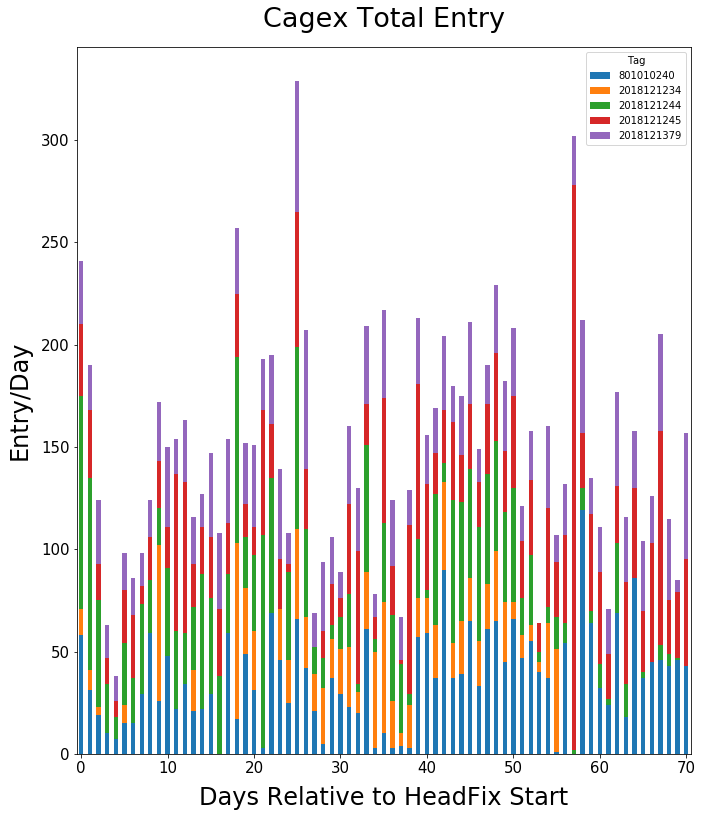

In [24]:
'''
df_Headfix started 2019-10-13 (lose head fix)
df_entry: graph of entries by mouse/Tag
'''
df_entry=db_event_query_mice(tags,cage,'entry','2019-10-13')

Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials


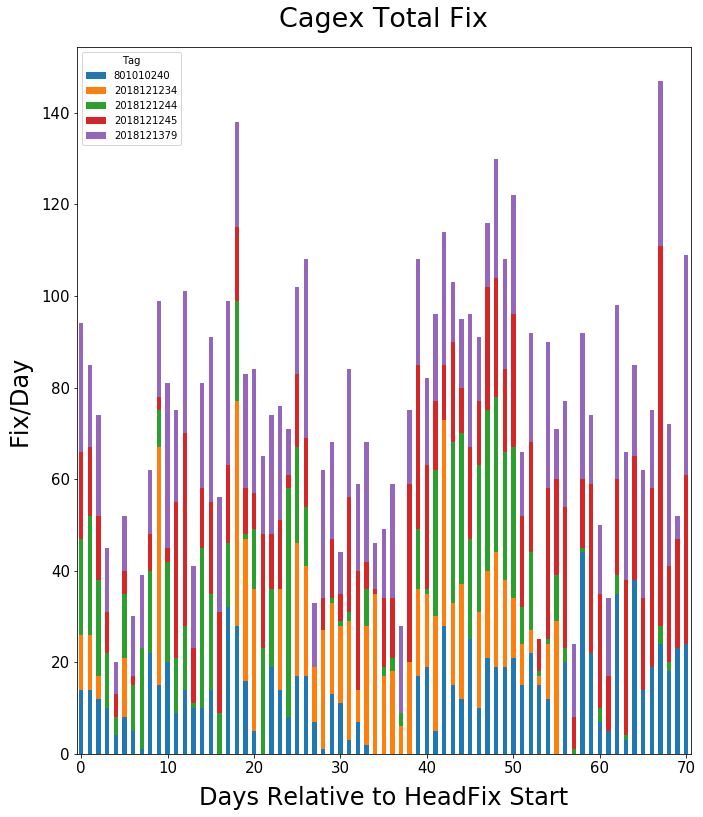

In [53]:
#df_Headfix started 2019-10-13 (lose head fix)
df_fix=db_event_query_mice(tags,cage,'Fix','2019-10-13')

In [50]:
#saving the df fo total fixes per day for later use
df_fix.to_csv('Total_headfixes_pertag')

Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials
Succesfully conected to local database using default credentials


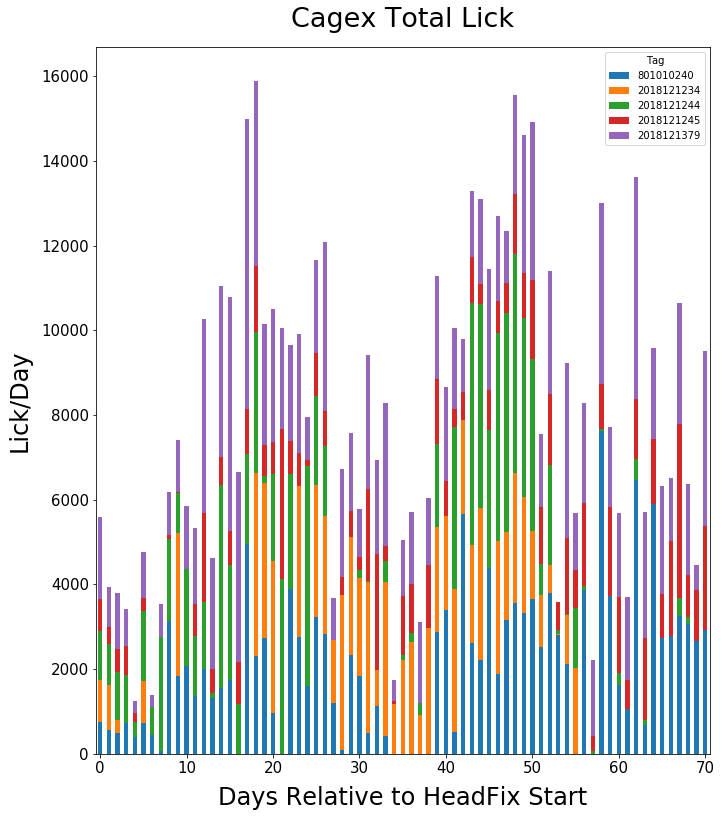

In [54]:
#the lick event plot started from 2019-10-13, (lose head fix)
df_licks=db_event_query_mice(tags,cage,'lick','2019-10-13')

Cage data to convert to text_logcagex
Enter start date to look at (YYYY-MM-DD):2019-10-13
Enter end date to look at(YYYY-MM-DD):2019-12-22
Succesfully conected to local database using default credentials
BrainLEDON event not at 3
BrainLEDON event not at 34
HeadFix event number 3 with no VIDEOSTART deleted
HeadFix event number 34 with no VIDEOSTART deleted
Multiple VideoEnd or VideoStart detected in index: 3
Multiple VideoEnd or VideoStart detected in index: 16
HeadFix event number 3 with Multiple VideoEnd or VideoStart deleted
HeadFix event number 16 with Multiple VideoEnd or VideoStart deleted
2019-10-13 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-14 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
Multiple Vid

All Headfix sessions have one VideoStart and VideoEnd event
2019-11-14 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-15 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-16 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-17 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-18 Headfix Session df created
Succesfull

No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-19 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-20 Headfix Session df created
Succesfully conected to local database using default credentials
VideoStart event not at 47
HeadFix event number 47 with no VIDEOSTART deleted
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-21 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-22 Headfix Session df created
All processes completed
801010240
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
error at17, no event for tag801010240
18
19
20
21
error at22, no event for tag8010

Text(0.5, 1.0, 'HeadFixed Time')

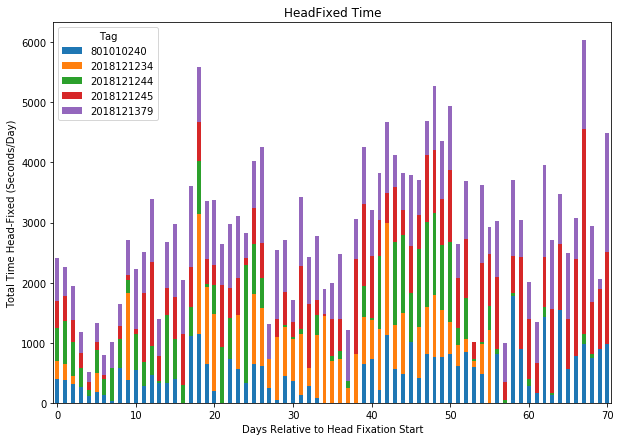

In [30]:
######have some problems calculating head fix time just using sql (Have some period of long time due to missing logs)
######Unsure of the cause
###### as a work around will be using the sum of duration dervied from the Head_fix_range() function
######takes a while to run since it queries the db again 
###### cage to querry: cagex 
######Start day for first headfix (loose) is 2019-10-13
######last day of headfix is 2019-12-22
######returns the plot for total headfix time to Days (Relative to Headfixation Start)
######also returns df (df_headfix_time)
######the df master_list generated is used down below
df_HeadFix_Time=Head_fix_range()
master_list=[]
for i in tags:
    templist=[]
    print(i)
    count=0
    for z in df_HeadFix_Time:
        count+=1
        try:
            templist.append(z[str(i)])
            print(count)
        except Exception as e:
            print('error at'+str(count)+', no event for tag'+str(i))
    templist=pd.concat(templist)
    master_list.append(templist)
master_list=pd.concat(master_list)
df_headfix_time = (master_list.groupby(['Tag', pd.Grouper(key='Session_Start_Time',freq='1D')])).sum()
df_headfix_time=df_headfix_time.reset_index()
df_headfix_time=df_headfix_time[['Tag','Session_Start_Time','Session_Duration(s)']]
df_headfix_time=df_headfix_time.pivot(index='Session_Start_Time',columns='Tag',values='Session_Duration(s)')
df_headfix_time['HeadFixStartDay']=[i for i in range(len(df_headfix_time.index))]
df_headfix_time=df_headfix_time.reset_index()
df_headfix_time=df_headfix_time.set_index('HeadFixStartDay')
df_headfix_time.drop(columns=['Session_Start_Time'])
ax=df_headfix_time.loc[:,tags].plot.bar(stacked=True, figsize=(10,7))
ax.set_ylabel('Total Time Head-Fixed (Seconds/Day)')
ax.set_xlabel('Days Relative to Head Fixation Start')
n=10
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n],rotation=360) 
ax.set_title('HeadFixed Time')

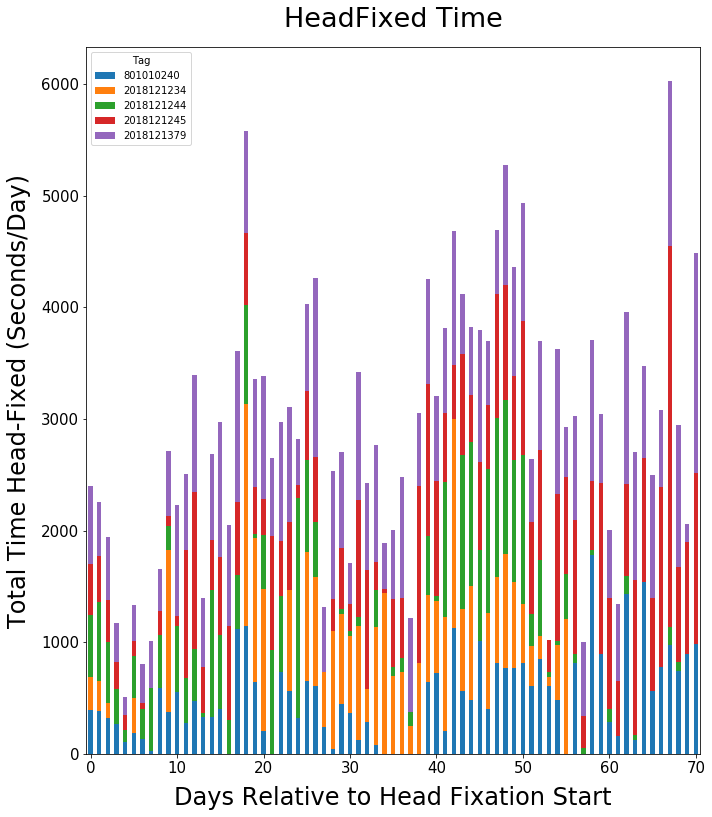

In [31]:
#reploting the graph from the previous cell, to avoid the the long lines of output
ax=df_headfix_time.loc[:,tags].plot.bar(stacked=True, figsize=(11,13))
ax.set_ylabel('Total Time Head-Fixed (Seconds/Day)',size=24, labelpad=10)
ax.set_xlabel('Days Relative to Head Fixation Start',size=24, labelpad=10)
n=10
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n],rotation=360) 
ax.set_title('HeadFixed Time', size= 27, pad=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('HeadFixed_Total_Time.svg')

In [47]:
#saves the df_head_time to csv for later sue 
df_headfix_time.to_csv('HFX_duration_permice.csv')

/alder/apps/jupyter/generic-01/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


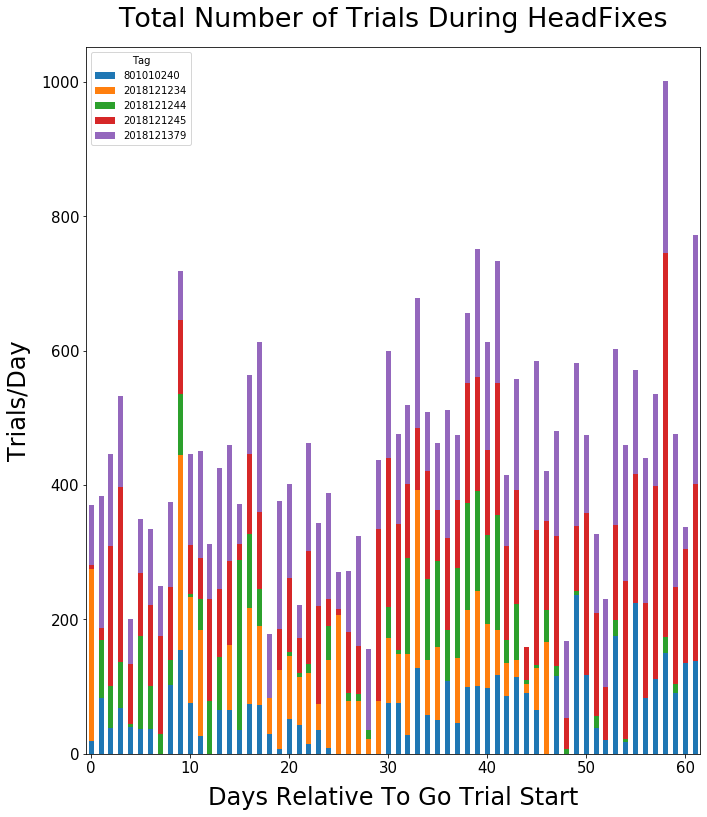

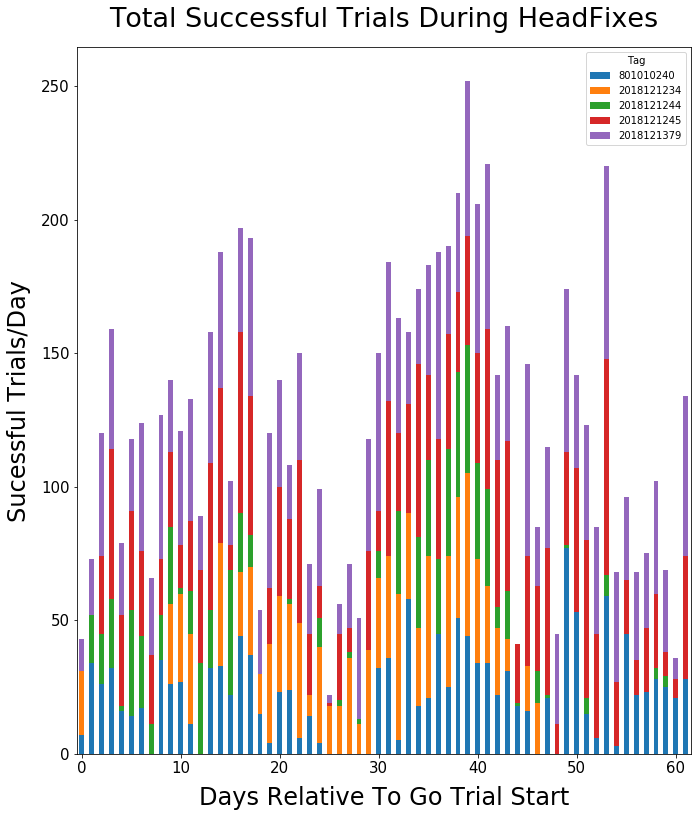

In [33]:
#####using the df generated from the previous cell (masterlist) 
#####creates two dfs
#####one df with n trials by each mice by day (df_trial_number)
#####one df with n sucessiful trilas by each mice by each day (df_trial_sucess_number)
#####plots 1. n trials and2. n sucessful trials graph
#####saves the graphs as svg
#####master_list3 still used for cells below
master_list2=master_list[master_list.Number_of_Trials !=0]
Sucess_count=[i.count(2) for i in master_list2.Trial_outcomes]
master_list2['Sucess_count']=Sucess_count
master_list3= master_list2[['Tag','Session_Start_Time','Number_of_Trials','Sucess_count']]
df_trial= (master_list3.groupby(['Tag', pd.Grouper(key='Session_Start_Time',freq='1D')])).sum()
df_trial=df_trial.reset_index()
df_trial_number=df_trial.pivot(index='Session_Start_Time',columns='Tag',values='Number_of_Trials')
df_trial_number['HeadFixStartDay']=[i for i in range(len(df_trial_number.index))]
df_trial_number=df_trial_number.reset_index()
df_tria_number=df_trial_number.set_index('HeadFixStartDay')
df_trial_number=df_trial_number.drop(columns='Session_Start_Time')
df_trial_sucess_number=df_trial.pivot(index='Session_Start_Time',columns='Tag',values='Sucess_count')
df_trial_sucess_number['HeadFixStartDay']=[i for i in range(len(df_trial_sucess_number.index))]
df_trial_sucess_number=df_trial_sucess_number.reset_index()
df_trial_sucess_number=df_trial_sucess_number.set_index('HeadFixStartDay')
df_trial_sucess_number=df_trial_sucess_number.drop(columns='Session_Start_Time')
ax=df_trial_number.loc[:,tags].plot.bar(stacked=True, figsize=(11,13))
n=10
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n],rotation=360) 
ax.set_xlabel('Days Relative To Go Trial Start',size=24, labelpad=10)
ax.set_title('Total Number of Trials During HeadFixes',size=27, pad=20)
ax.set_ylabel('Trials/Day',size=24, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('Total_Number_Trial.svg')
ax2=df_trial_sucess_number.loc[:,tags].plot.bar(stacked=True, figsize=(11,13))
ax2.xaxis.set_ticks(ticks[::n])
ax2.xaxis.set_ticklabels(ticklabels[::n],rotation=360) 
ax2.set_title('Total Successful Trials During HeadFixes',size=27, pad=20)
ax2.set_xlabel('Days Relative To Go Trial Start',size=24, labelpad=10)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylabel('Sucessful Trials/Day',size=24, labelpad=10)
plt.savefig('Total_Number_Successful_Trial.svg')

Succesfully conected to local database using default credentials


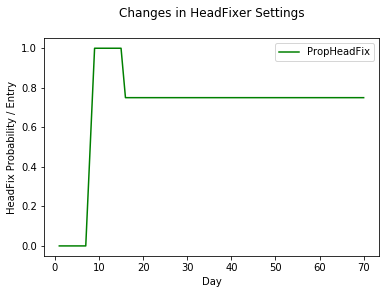

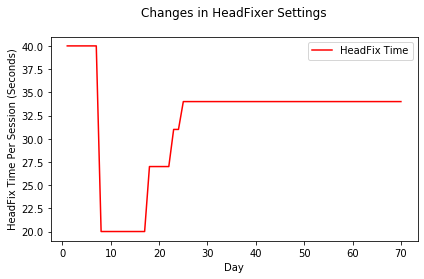

In [34]:
#changes in headfixer (propheadfix, and headfix time)
#returns df
df_headFixer=db_headfixer_config(cage)

Succesfully conected to local database using default credentials


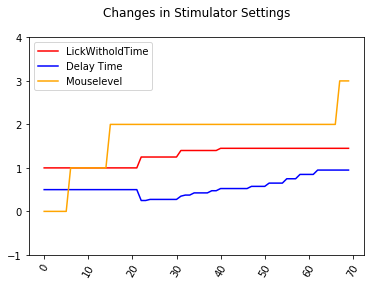

In [35]:
#Stimulator setting for mice 
#returns df
df_stimulator=db_Stimulator_config(cage)

In [26]:
# a list of dictionaries containning the headfix session of by mouse
#go session started on 2019-10-23
#go session end date on 2019-12-08
#cage is cagex
#takes some time as the query is ran
#when compelted: all process are complete will be printed 
#after running use the cell below to graph each mouse 
df_go_trial_HeadFix=Head_fix_range()

Cage data to convert to text_logcagex
Enter start date to look at (YYYY-MM-DD):2019-10-23
Enter end date to look at(YYYY-MM-DD):2019-12-08
Succesfully conected to local database using default credentials
VideoStart event not at 77
HeadFix event number 77 with no VIDEOSTART deleted
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-23 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-24 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-25 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and Vide

2019-11-26 Headfix Session df created
Succesfully conected to local database using default credentials
VideoStart event not at 19
HeadFix event number 19 with no VIDEOSTART deleted
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-27 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-28 Headfix Session df created
Succesfully conected to local database using default credentials
No extra videostarts detected in all headfix/nofix sessions
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-29 Headfix Session df created
Succesfully conected to local database using default credentials
VideoStart event not at 60
HeadFix event number 60 with no VIDEOSTART deleted
All Headfix sessions have one VideoStart and VideoEnd event
2019-11-30 Headfix Session df created
Succesfully conected to local data

Outcome code to look for -2
801010240
At day 1, no lick log for 801010240
At day 2, no lick log for 801010240
At day 3, no lick log for 801010240
At day 4, no lick log for 801010240
At day 5, no lick log for 801010240
At day 6, no lick log for 801010240
At day 7, no lick log for 801010240
At day 8, no lick log for 801010240
At day 9, no lick log for 801010240
At day 10, no lick log for 801010240
At day 11, no lick log for 801010240
At day 12, no lick log for 801010240
At day 13, no lick log for 801010240
At day 14, no lick log for 801010240
At day 15, no lick log for 801010240
At day 16, no lick log for 801010240
At day 17, no lick log for 801010240
At day 18, no lick log for 801010240
At day 19, no lick log for 801010240
At day 20, no lick log for 801010240
At day 21, no lick log for 801010240
At day 22, no lick log for 801010240
At day 23, no lick log for 801010240
At day 24, no lick log for 801010240
At day 25, no lick log for 801010240
At day 26, no lick log for 801010240
At day 27

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 4 1571876087.27 1571876087.69
No next trial found using session end time as final trial end time
2018121379 9 1571877485.85 1571877486.25
No next trial found using session end time as final trial end time
2018121379 10 1571877526.78 1571877527.24
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 18 1571887868.54 1571887868.96
No next trial found using session end time as final trial end time
2018121379 19 1571887908.68 1571887908.78
No next trial found using session end time as final tri

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 617 1572668595.41 1572668595.53
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end 

No next trial found using session end time as final trial end time
2018121379 1365 1572309319.55 1572309319.73
2018121379 1366 1572309357.92 1572309358.12
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1429 1572838790.96 1572838791.15
2018121379 1445 1572841594.58 1572841594.72
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1491 1573

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1916 1571972255.62 1571972256.03
2018121379 1916 1571972275.61 1571972275.99
2018121379 1916 1571972275.75 1571972275.99
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end ti

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2094 1572860960.84 1572860960.97
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial foun

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2305 1574304412.09 1574304412.28
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial foun

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2501 1575175912.41 1575175912.55
No next trial found using session end time as final trial end time
2018121379 2502 1575176162.77 1575176162.96
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end tim

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2708 1571875585.2 1571875585.33
2018121379 2708 1571875585.34 1571875585.33
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2711 1571877330.34 1571877330.79
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2713 1571877423.73 1571877424.11
2018121379 2713 1571877423.86 1571877424.11
2018121379 2713 1571877433.43 1571877433.61


No next trial found using session end time as final trial end time
2018121379 2912 1572483291.28 1572483291.37
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial foun

2018121379 3228 1573714033.18 1573714033.31
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3234 1573714374.32 1573714374.47
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3245 1573783249.47 1573783249.59
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end ti

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3546 1575172913.08 1575172913.28
2018121379 3546 1575172935.46 1575172935.52
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3560 1575174788.07 1575174788.26
2018121379 3560 1575174788.21 1575174788.26
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found 

No next trial found using session end time as final trial end time
2018121379 0 1571875907.27 1571875907.67
2018121379 0 1571875907.4 1571875907.67
2018121379 0 1571875907.42 1571875907.67
2018121379 0 1571875907.52 1571875907.67
2018121379 0 1571875907.66 1571875907.67
2018121379 0 1571875913.01 1571875913.14
2018121379 1 1571875947.12 1571875947.18
2018121379 1 1571875947.26 1571875947.18
2018121379 3 1571876036.44 1571876036.62
2018121379 3 1571876036.65 1571876036.62
2018121379 4 1571876077.49 1571876077.93
2018121379 4 1571876077.63 1571876077.93
2018121379 4 1571876077.75 1571876077.93
2018121379 4 1571876077.88 1571876077.93
2018121379 4 1571876078.01 1571876077.93
2018121379 7 1571876201.65 1571876201.78
2018121379 7 1571876205.4 1571876205.35
No next trial found using session end time as final trial end time
2018121379 8 1571876557.2 1571876557.54
2018121379 8 1571876557.38 1571876557.54
2018121379 9 1571877479.21 1571877479.28
2018121379 9 1571877479.37 1571877479.28
No next 

No next trial found using session end time as final trial end time
2018121379 108 1572569437.28 1572569437.34
2018121379 108 1572569437.41 1572569437.34
2018121379 108 1572569440.62 1572569440.64
2018121379 108 1572569442.78 1572569442.91
2018121379 108 1572569447.93 1572569447.88
2018121379 108 1572569451.46 1572569451.5
2018121379 108 1572569451.59 1572569451.5
2018121379 109 1572569635.13 1572569635.06
No next trial found using session end time as final trial end time
2018121379 110 1572569755.85 1572569755.98
2018121379 110 1572569755.96 1572569755.98
2018121379 110 1572569756.07 1572569755.98
2018121379 110 1572569769.42 1572569769.42
2018121379 110 1572569773.6 1572569773.51
2018121379 111 1572569792.51 1572569792.43
No next trial found using session end time as final trial end time
2018121379 112 1572569850.76 1572569850.85
2018121379 112 1572569850.88 1572569850.85
2018121379 112 1572569862.07 1572569862.05
No next trial found using session end time as final trial end time
2018

2018121379 297 1574568361.25 1574568361.16
No next trial found using session end time as final trial end time
2018121379 299 1574578477.61 1574578477.53
2018121379 299 1574578494.9 1574578494.84
2018121379 300 1574578695.57 1574578695.64
2018121379 300 1574578695.7 1574578695.64
2018121379 300 1574578710.18 1574578710.35
2018121379 300 1574578710.3 1574578710.35
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 306 1574664039.99 1574664039.92
2018121379 312 1574664534.46 1574664534.64
2018121379 312 1574664534.58 1574664534.64
2018121379 312 1574664534.72 1574664534.64
2018121379 313 1574664585.0 1574664585.17
2018121379 313 1574664585.13 1574664585.17
2018121379 313 1574664585.26 1574664585.17
2018121379 313 1574664592.02 1574664592.21
2018121379 313 1574664592.15 1574664592.21
2018121379 313 1574664592.26 1574664592.21
2018121379 316 1574667415.03 1574667415.23
2018121379 316 1574667415.16 

No next trial found using session end time as final trial end time
2018121379 449 1575342094.33 1575342094.37
2018121379 449 1575342094.44 1575342094.37
2018121379 449 1575342114.22 1575342114.33
2018121379 449 1575342114.36 1575342114.33
2018121379 450 1575342276.98 1575342276.9
2018121379 450 1575342280.89 1575342281.06
2018121379 450 1575342281.0 1575342281.06
2018121379 450 1575342281.12 1575342281.06
No next trial found using session end time as final trial end time
2018121379 451 1575342346.88 1575342346.94
2018121379 451 1575342346.99 1575342346.94
2018121379 451 1575342352.94 1575342352.98
2018121379 451 1575342353.06 1575342352.98
2018121379 451 1575342355.95 1575342356.09
2018121379 451 1575342356.07 1575342356.09
2018121379 452 1575342470.63 1575342470.63
No next trial found using session end time as final trial end time
2018121379 453 1575342531.92 1575342531.93
2018121379 453 1575342537.57 1575342537.52
No next trial found using session end time as final trial end time
201

No next trial found using session end time as final trial end time
2018121379 534 1575883516.86 1575883516.97
2018121379 534 1575883516.97 1575883516.97
2018121379 534 1575883520.29 1575883520.21
No next trial found using session end time as final trial end time
2018121379 535 1575883776.25 1575883776.18
No next trial found using session end time as final trial end time
2018121379 537 1575883980.41 1575883980.4
2018121379 537 1575883985.69 1575883985.8
2018121379 537 1575883985.8 1575883985.8
No next trial found using session end time as final trial end time
2018121379 540 1575884151.97 1575884151.95
No next trial found using session end time as final trial end time
2018121379 543 1575884334.21 1575884334.36
2018121379 543 1575884334.32 1575884334.36
2018121379 543 1575884334.44 1575884334.36
2018121379 543 1575884339.93 1575884339.99
2018121379 543 1575884340.05 1575884339.99
2018121379 545 1575884449.5 1575884449.51
2018121379 545 1575884449.59 1575884449.51
No next trial found using

2018121379 834 1573725318.8 1573725318.87
2018121379 834 1573725318.96 1573725318.87
2018121379 836 1573804929.91 1573804929.87
2018121379 840 1573805834.77 1573805834.88
2018121379 840 1573805834.89 1573805834.88
2018121379 841 1573809235.77 1573809235.9
2018121379 841 1573809235.89 1573809235.9
2018121379 847 1573875768.41 1573875768.55
2018121379 847 1573875768.54 1573875768.55
2018121379 847 1573875776.26 1573875776.39
2018121379 847 1573875776.38 1573875776.39
2018121379 851 1573876195.78 1573876195.86
2018121379 851 1573876195.91 1573876195.86
2018121379 856 1573877725.34 1573877725.29
2018121379 856 1573877740.2 1573877740.17
2018121379 860 1573887538.57 1573887538.65
2018121379 860 1573887538.69 1573887538.65
No next trial found using session end time as final trial end time
2018121379 865 1573893800.0 1573893799.99
No next trial found using session end time as final trial end time
2018121379 869 1573958230.29 1573958230.33
2018121379 869 1573958230.42 1573958230.33
No next tri

2018121379 1117 1574993207.16 1574993207.14
2018121379 1119 1574993294.53 1574993294.55
2018121379 1121 1574993436.93 1574993436.94
2018121379 1122 1574993700.34 1574993700.54
2018121379 1122 1574993700.5 1574993700.54
2018121379 1122 1574993700.63 1574993700.54
2018121379 1122 1574993708.18 1574993708.18
2018121379 1125 1574994386.71 1574994386.78
2018121379 1125 1574994386.86 1574994386.78
2018121379 1126 1574994955.45 1574994955.58
2018121379 1127 1574995499.08 1574995499.23
2018121379 1128 1574996411.63 1574996411.74
2018121379 1130 1574996501.4 1574996501.59
2018121379 1133 1575015751.16 1575015751.26
2018121379 1133 1575015751.35 1575015751.26
2018121379 1134 1575072010.77 1575072010.73
2018121379 1134 1575072019.59 1575072019.73
2018121379 1134 1575072019.76 1575072019.73
2018121379 1135 1575072215.76 1575072215.9
2018121379 1135 1575072215.89 1575072215.9
2018121379 1137 1575072428.6 1575072428.78
2018121379 1137 1575072428.79 1575072428.78
No next trial found using session end

2018121379 1309 1572047642.94 1572047642.89
2018121379 1309 1572047651.29 1572047651.21
No next trial found using session end time as final trial end time
2018121379 1310 1572058822.14 1572058822.33
2018121379 1310 1572058836.86 1572058837.02
2018121379 1310 1572058837.02 1572058837.02
2018121379 1310 1572058838.11 1572058838.29
2018121379 1310 1572058838.32 1572058838.29
2018121379 1310 1572058840.64 1572058840.79
2018121379 1311 1572058961.72 1572058961.72
No next trial found using session end time as final trial end time
2018121379 1312 1572059042.23 1572059042.28
2018121379 1312 1572059042.35 1572059042.28
2018121379 1313 1572059819.93 1572059819.94
2018121379 1313 1572059826.82 1572059827.01
2018121379 1313 1572059827.0 1572059827.01
2018121379 1314 1572059943.9 1572059943.94
2018121379 1314 1572059944.02 1572059943.94
No next trial found using session end time as final trial end time
2018121379 1315 1572139767.26 1572139767.39
No next trial found using session end time as final t

2018121379 1457 1572941872.24 1572941872.32
2018121379 1457 1572941872.38 1572941872.32
2018121379 1457 1572941880.88 1572941881.0
2018121379 1457 1572941881.0 1572941881.0
No next trial found using session end time as final trial end time
2018121379 1458 1572941956.64 1572941956.77
2018121379 1458 1572941956.78 1572941956.77
2018121379 1458 1572941957.96 1572941958.09
2018121379 1458 1572941958.1 1572941958.09
2018121379 1459 1572942042.23 1572942042.16
2018121379 1460 1572942089.53 1572942089.64
2018121379 1460 1572942089.66 1572942089.64
2018121379 1460 1572942113.64 1572942113.81
2018121379 1460 1572942113.82 1572942113.81
2018121379 1461 1572942140.37 1572942140.34
No next trial found using session end time as final trial end time
2018121379 1463 1572942448.74 1572942448.87
2018121379 1463 1572942448.89 1572942448.87
2018121379 1463 1572942471.63 1572942471.59
No next trial found using session end time as final trial end time
2018121379 1464 1572942619.6 1572942619.8
2018121379 14

No next trial found using session end time as final trial end time
2018121379 1633 1574737302.7 1574737302.75
2018121379 1633 1574737302.84 1574737302.75
2018121379 1633 1574737315.3 1574737315.33
No next trial found using session end time as final trial end time
2018121379 1634 1574737360.64 1574737360.59
No next trial found using session end time as final trial end time
2018121379 1635 1574737393.35 1574737393.29
2018121379 1635 1574737408.0 1574737408.0
2018121379 1635 1574737411.45 1574737411.59
2018121379 1635 1574737411.62 1574737411.59
2018121379 1637 1574737549.77 1574737549.93
2018121379 1637 1574737549.89 1574737549.93
No next trial found using session end time as final trial end time
2018121379 1640 1574737691.54 1574737691.5
2018121379 1640 1574737710.05 1574737710.19
2018121379 1642 1574737838.4 1574737838.51
2018121379 1642 1574737838.55 1574737838.51
2018121379 1642 1574737851.13 1574737851.2
2018121379 1642 1574737858.55 1574737858.59
No next trial found using session e

2018121379 1776 1575174876.2 1575174876.34
2018121379 1776 1575174876.34 1575174876.34
2018121379 1776 1575174889.91 1575174889.97
2018121379 1776 1575174891.22 1575174891.31
2018121379 1776 1575174891.34 1575174891.31
2018121379 1777 1575175034.41 1575175034.56
2018121379 1779 1575175124.75 1575175124.82
2018121379 1779 1575175129.43 1575175129.45
No next trial found using session end time as final trial end time
2018121379 1783 1575175519.0 1575175518.99
2018121379 1783 1575175525.54 1575175525.5
2018121379 1783 1575175529.58 1575175529.59
No next trial found using session end time as final trial end time
2018121379 1785 1575175696.48 1575175696.55
2018121379 1785 1575175696.62 1575175696.55
No next trial found using session end time as final trial end time
2018121379 1786 1575177361.08 1575177361.17
2018121379 1786 1575177361.21 1575177361.17
2018121379 1786 1575177373.04 1575177373.11
2018121379 1786 1575177373.17 1575177373.11
2018121379 1786 1575177375.39 1575177375.59
2018121379

2018121379 1879 1575513661.31 1575513661.4
2018121379 1879 1575513672.15 1575513672.1
2018121379 1879 1575513677.12 1575513677.03
2018121379 1879 1575513679.54 1575513679.69
2018121379 1879 1575513679.7 1575513679.69
No next trial found using session end time as final trial end time
2018121379 1880 1575513729.93 1575513730.06
2018121379 1880 1575513730.07 1575513730.06
No next trial found using session end time as final trial end time
2018121379 1881 1575597703.09 1575597703.15
2018121379 1881 1575597703.24 1575597703.15
2018121379 1881 1575597714.84 1575597714.8
No next trial found using session end time as final trial end time
2018121379 1884 1575776306.61 1575776306.7
2018121379 1884 1575776306.75 1575776306.7
2018121379 1884 1575776315.61 1575776315.6
No next trial found using session end time as final trial end time
2018121379 1885 1575776356.55 1575776356.7
2018121379 1885 1575776356.67 1575776356.7
2018121379 1885 1575776374.01 1575776373.98
No next trial found using session end

2018121379 2127 1573002910.85 1573002911.0
2018121379 2127 1573002911.01 1573002911.0
2018121379 2130 1573003473.61 1573003473.56
2018121379 2133 1573026562.91 1573026562.84
2018121379 2133 1573026564.81 1573026564.78
No next trial found using session end time as final trial end time
2018121379 2143 1573091975.53 1573091975.63
2018121379 2143 1573091975.7 1573091975.63
2018121379 2143 1573091995.25 1573091995.18
2018121379 2143 1573091997.5 1573091997.43
2018121379 2145 1573194887.49 1573194887.57
2018121379 2145 1573194887.63 1573194887.57
No next trial found using session end time as final trial end time
2018121379 2147 1573195193.33 1573195193.29
2018121379 2149 1573195363.92 1573195364.06
2018121379 2149 1573195364.04 1573195364.06
2018121379 2149 1573195364.06 1573195364.06
2018121379 2149 1573195367.31 1573195367.39
2018121379 2149 1573195372.86 1573195372.91
2018121379 2151 1573195537.71 1573195537.62
2018121379 2152 1573195680.95 1573195680.87
2018121379 2153 1573195799.7 15731

No next trial found using session end time as final trial end time
2018121379 2468 1575015675.37 1575015675.34
2018121379 2471 1575016028.15 1575016028.33
2018121379 2472 1575016078.12 1575016078.23
2018121379 2472 1575016078.29 1575016078.23
2018121379 2498 1575095091.98 1575095091.94
2018121379 2498 1575095093.57 1575095093.55
2018121379 2505 1575176376.98 1575176376.96
2018121379 2505 1575176389.96 1575176389.93
2018121379 2508 1575176589.99 1575176590.03
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2515 1575186856.68 1575186856.69
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2535 1575273894.18 1575273894.11
2018121379 2537 1575273985.24 1575273985.33
No next trial found using session end time as final trial end time
201

2018121379 2787 1572058654.86 1572058655.0
2018121379 2787 1572058654.97 1572058655.0
2018121379 2787 1572058655.09 1572058655.0
2018121379 2806 1572138999.62 1572138999.64
2018121379 2806 1572138999.72 1572138999.64
2018121379 2808 1572139879.22 1572139879.4
2018121379 2808 1572139879.38 1572139879.4
2018121379 2809 1572139941.29 1572139941.22
2018121379 2810 1572225123.81 1572225124.0
2018121379 2810 1572225124.04 1572225124.0
2018121379 2810 1572225128.66 1572225128.72
2018121379 2810 1572225128.77 1572225128.72
2018121379 2812 1572225232.53 1572225232.68
2018121379 2812 1572225232.65 1572225232.68
2018121379 2814 1572225324.54 1572225324.45
2018121379 2814 1572225326.03 1572225326.15
2018121379 2814 1572225326.18 1572225326.15
2018121379 2817 1572225464.45 1572225464.52
2018121379 2817 1572225464.58 1572225464.52
2018121379 2819 1572225619.46 1572225619.62
2018121379 2819 1572225619.6 1572225619.62
2018121379 2819 1572225619.71 1572225619.62
2018121379 2820 1572225658.55 1572225658

No next trial found using session end time as final trial end time
2018121379 2964 1572655497.07 1572655497.18
2018121379 2964 1572655497.19 1572655497.18
2018121379 2964 1572655505.18 1572655505.34
2018121379 2964 1572655505.31 1572655505.34
2018121379 2964 1572655517.08 1572655517.05
2018121379 2967 1572669307.45 1572669307.6
2018121379 2967 1572669307.56 1572669307.6
2018121379 2967 1572669307.68 1572669307.6
2018121379 2971 1572669547.24 1572669547.33
2018121379 2971 1572669547.35 1572669547.33
No next trial found using session end time as final trial end time
2018121379 2972 1572669580.39 1572669580.54
2018121379 2972 1572669580.52 1572669580.54
2018121379 2972 1572669585.31 1572669585.28
2018121379 2977 1572738309.48 1572738309.49
2018121379 2978 1572738447.34 1572738447.44
2018121379 2978 1572738447.46 1572738447.44
2018121379 2980 1572738672.0 1572738671.93
No next trial found using session end time as final trial end time
2018121379 2984 1572739378.1 1572739378.15
2018121379 2

No next trial found using session end time as final trial end time
2018121379 3098 1573197420.76 1573197420.79
No next trial found using session end time as final trial end time
2018121379 3100 1573197518.48 1573197518.45
2018121379 3101 1573263760.13 1573263760.04
No next trial found using session end time as final trial end time
2018121379 3104 1573263950.93 1573263950.9
2018121379 3105 1573264025.64 1573264025.72
2018121379 3106 1573264059.85 1573264060.04
2018121379 3106 1573264059.95 1573264060.04
2018121379 3106 1573264060.07 1573264060.04
No next trial found using session end time as final trial end time
2018121379 3108 1573264213.7 1573264213.64
2018121379 3108 1573264221.95 1573264222.11
2018121379 3108 1573264222.09 1573264222.11
2018121379 3108 1573264226.87 1573264227.06
2018121379 3108 1573264226.99 1573264227.06
2018121379 3108 1573264227.11 1573264227.06
No next trial found using session end time as final trial end time
2018121379 3109 1573264276.21 1573264276.39
2018121

2018121379 3250 1573783593.34 1573783593.44
2018121379 3250 1573783593.48 1573783593.44
2018121379 3250 1573783599.92 1573783599.91
2018121379 3253 1573805811.52 1573805811.57
2018121379 3253 1573805811.65 1573805811.57
No next trial found using session end time as final trial end time
2018121379 3255 1573805968.57 1573805968.7
2018121379 3255 1573805968.66 1573805968.7
2018121379 3260 1573869485.05 1573869484.97
2018121379 3260 1573869487.89 1573869488.08
2018121379 3260 1573869488.01 1573869488.08
2018121379 3260 1573869488.1 1573869488.08
2018121379 3261 1573869526.13 1573869526.16
2018121379 3261 1573869526.22 1573869526.16
No next trial found using session end time as final trial end time
2018121379 3263 1573874589.76 1573874589.83
2018121379 3263 1573874589.9 1573874589.83
2018121379 3263 1573874603.15 1573874603.15
2018121379 3263 1573874606.24 1573874606.28
2018121379 3263 1573874606.34 1573874606.28
2018121379 3265 1573874844.59 1573874844.6
2018121379 3265 1573874848.56 15738

2018121379 3409 1574491639.56 1574491639.64
2018121379 3409 1574491639.68 1574491639.64
2018121379 3410 1574491676.1 1574491676.03
2018121379 3410 1574491685.18 1574491685.29
2018121379 3410 1574491685.31 1574491685.29
2018121379 3411 1574491750.82 1574491750.85
2018121379 3412 1574568642.42 1574568642.47
2018121379 3412 1574568642.52 1574568642.47
2018121379 3412 1574568651.14 1574568651.19
2018121379 3412 1574568653.43 1574568653.48
2018121379 3412 1574568653.56 1574568653.48
2018121379 3414 1574568857.18 1574568857.28
2018121379 3414 1574568857.3 1574568857.28
No next trial found using session end time as final trial end time
2018121379 3415 1574568895.07 1574568895.2
2018121379 3415 1574568895.19 1574568895.2
2018121379 3415 1574568903.0 1574568903.03
2018121379 3417 1574568998.39 1574568998.46
2018121379 3417 1574568998.5 1574568998.46
2018121379 3417 1574569007.8 1574569007.75
2018121379 3417 1574569010.33 1574569010.37
2018121379 3417 1574569010.46 1574569010.37
2018121379 3418 

No next trial found using session end time as final trial end time
2018121379 3566 1575186350.47 1575186350.43
2018121379 3566 1575186376.23 1575186376.42
2018121379 3566 1575186376.36 1575186376.42
2018121379 3566 1575186376.49 1575186376.42
2018121379 3567 1575186412.76 1575186412.84
2018121379 3567 1575186412.89 1575186412.84
2018121379 3568 1575186565.46 1575186565.37
2018121379 3568 1575186567.03 1575186566.97
2018121379 3569 1575186628.3 1575186628.39
2018121379 3569 1575186628.42 1575186628.39
2018121379 3569 1575186643.99 1575186643.92
2018121379 3570 1575186692.02 1575186691.97
No next trial found using session end time as final trial end time
2018121379 3571 1575260717.65 1575260717.58
2018121379 3571 1575260720.24 1575260720.37
2018121379 3571 1575260720.35 1575260720.37
2018121379 3571 1575260720.46 1575260720.37
2018121379 3572 1575260776.7 1575260776.89
2018121379 3572 1575260776.81 1575260776.89
2018121379 3572 1575260776.93 1575260776.89
No next trial found using sessio

No next trial found using session end time as final trial end time
2018121379 3649 1575534649.19 1575534649.17
No next trial found using session end time as final trial end time
2018121379 3650 1575534717.4 1575534717.56
2018121379 3650 1575534717.52 1575534717.56
2018121379 3650 1575534733.31 1575534733.22
No next trial found using session end time as final trial end time
2018121379 3652 1575534903.37 1575534903.5
2018121379 3652 1575534903.47 1575534903.5
2018121379 3652 1575534919.7 1575534919.67
2018121379 3653 1575535002.95 1575535003.07
2018121379 3653 1575535003.06 1575535003.07
No next trial found using session end time as final trial end time
2018121379 3654 1575535076.65 1575535076.67
2018121379 3654 1575535076.76 1575535076.67
2018121379 3655 1575535112.68 1575535112.84
2018121379 3655 1575535112.8 1575535112.84
2018121379 3655 1575535112.92 1575535112.84
2018121379 3655 1575535135.26 1575535135.3
2018121379 3656 1575535200.73 1575535200.79
2018121379 3656 1575535200.83 1575

2018121244
At day 1, no lick log for 2018121244
At day 2, no lick log for 2018121244
At day 3, no lick log for 2018121244
At day 4, no lick log for 2018121244
At day 5, no lick log for 2018121244
At day 6, no lick log for 2018121244
At day 7, no lick log for 2018121244
At day 8, no lick log for 2018121244
At day 9, no lick log for 2018121244
At day 10, no lick log for 2018121244
At day 11, no lick log for 2018121244
At day 12, no lick log for 2018121244
At day 13, no lick log for 2018121244
At day 14, no lick log for 2018121244
At day 15, no lick log for 2018121244
At day 16, no lick log for 2018121244
At day 17, no lick log for 2018121244
At day 18, no lick log for 2018121244
At day 19, no lick log for 2018121244
At day 20, no lick log for 2018121244
At day 21, no lick log for 2018121244
At day 22, no lick log for 2018121244
At day 23, no lick log for 2018121244
At day 24, no lick log for 2018121244
At day 25, no lick log for 2018121244
At day 26, no lick log for 2018121244
At day 27,

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 72 1572310433.2 1572310433.3
No next trial found us

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end 

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end 

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 796 1573616434.85 1573616435.02
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 800 1573616954.9 1573616955.06
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time a

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1097 1574817921.67 1574817921.72
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1105 1574824882.22 1574824882.28
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end tim

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1371 1572393127.2 1572393127.24
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1374 1572393387.57 1572393387.77
2018121379 1374 1572393387.77 1572393387.77
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1383 1572481042.84 1572481042.92
No next trial found using session end time as final trial end time
2018121379 1384 1572481137.28 1572481137.31
No next trial found using session end time a

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1622 1574736308.09 1574736308.09
No next trial found using session end time as final trial end time
2018121379 1623 1574736430.1 1574736430.26
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1851 1575340624.53 1575340624.58
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1854 1575343161.75 1575343161.76
No next trial found using session end time as final trial end time
2018121379 1856 1575343317.97 1575343318.15
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1862 1575444797.34 1575444797.51
No next trial found 

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2199 1573609153.43 1573609153.49
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2204 1573697556.37 1573697556.43
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2222 1573723905.24 1573723905.43
2018121379 2228 1573808037.69 1573808037.7
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found u

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2713 1571877419.4 1571877419.51
2018121379 2713 1571877419.52 1571877419.51
2018121379 2713 1571877427.89 1571877428.22
2018121379 2714 1571877796.63 1571877796.81
2018121379 2715 1571877837.76 1571877838.25
2018121379 2715 1571877838.03 1571877838.25
2018121379 2715 1571877838.16 1571877838.25
2018121379 2715 1571877838.29 1571877838.25
2018121379 2717 1571877907.83 1571877908.25
2018121379 2717 1571877908.25 1571877908.25
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2956 1572652862.12 1572652862.19
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2968 1572669374.92 1572669375.12
2018121379 2968 1572669384.59 1572669384.

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end 

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3518 1574994489.81 1574994489.96
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3521 1574994749.67 1574994749.79
2018121379 3521 1574994749.76 1574994749.79
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3530 1575016376.15 1575016376.34
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found 

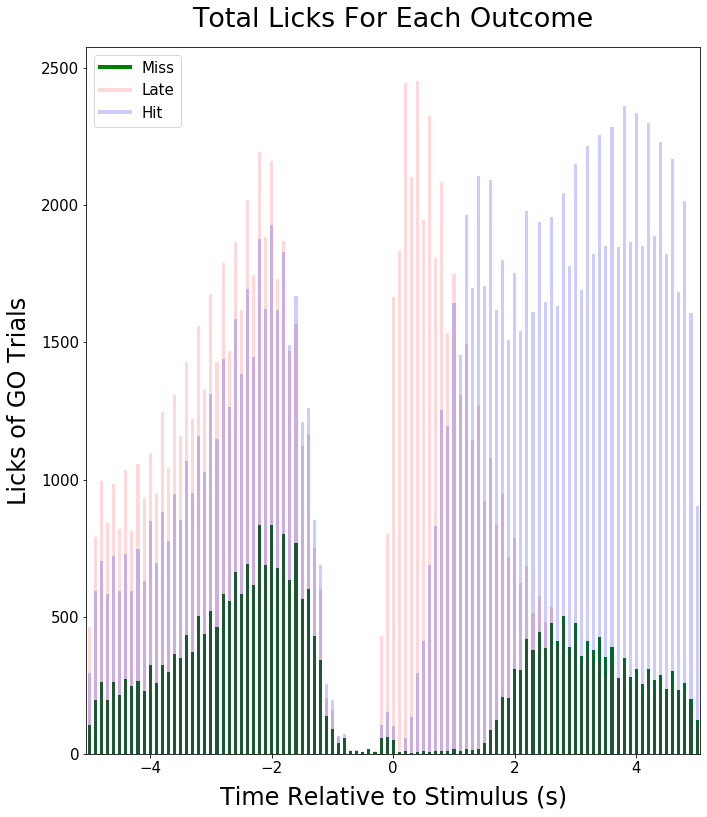

In [147]:
#To generate a list of df containing the outcome code desired 
#used outcome_lick function
#plots out the cumulative lick histogram for all mice and 
#Days with no lick detected will also be printed out
outcome_codes=[-2,-4,2]
list_licks=[]
for i in outcome_codes:
    print('Outcome code to look for '+ str(i))
    temp=outcome_licks(i,tags,df_go_trial_HeadFix)
    temp=temp[1]
    list_licks.append(temp)
custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='red', lw=4,alpha=0.15),
                Line2D([0], [0], color='blue', lw=4,alpha=0.2)]
plot_colors=['green','red','blue']
alpha=[1,0.15,0.2]
plt.figure(figsize=(11, 13))
for i,y,t in zip(list_licks,plot_colors,alpha):
    temp1=[z for z in i.licks_RelativeToTrial]
    temp2=list(itertools.chain.from_iterable(temp1))
    temp2=[round(z,1) for z in temp2]
    u,counts= np.unique(temp2, return_counts=True)
    plt.bar(u,counts,width=0.05,align='center',alpha=t,color=y)
    #ax=sns.barplot(u,counts,color=y,alpha=t)
    plt.xlim(-5.05,5.05)
    plt.ylabel('Licks of GO Trials', size=24,labelpad=10)
    plt.xlabel('Time Relative to Stimulus (s)',size=24,labelpad=10)
    plt.title('Total Licks For Each Outcome',size=27,pad=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(custom_lines,['Miss','Late','Hit'],prop={'size': 15})
plt.savefig('Total_Licks_for_Each_Outcome.svg')

In [148]:
temp=outcome_licks(-2,tags,df_go_trial_HeadFix)

801010240
At day 1, no lick log for 801010240
At day 2, no lick log for 801010240
At day 3, no lick log for 801010240
At day 4, no lick log for 801010240
At day 5, no lick log for 801010240
At day 6, no lick log for 801010240
At day 7, no lick log for 801010240
At day 8, no lick log for 801010240
At day 9, no lick log for 801010240
At day 10, no lick log for 801010240
At day 11, no lick log for 801010240
At day 12, no lick log for 801010240
At day 13, no lick log for 801010240
At day 14, no lick log for 801010240
At day 15, no lick log for 801010240
At day 16, no lick log for 801010240
At day 17, no lick log for 801010240
At day 18, no lick log for 801010240
At day 19, no lick log for 801010240
At day 20, no lick log for 801010240
At day 21, no lick log for 801010240
At day 22, no lick log for 801010240
At day 23, no lick log for 801010240
At day 24, no lick log for 801010240
At day 25, no lick log for 801010240
At day 26, no lick log for 801010240
At day 27, no lick log for 801010240


No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 4 1571876087.27 1571876087.69
No next trial found using session end time as final trial end time
2018121379 9 1571877485.85 1571877486.25
No next trial found using session end time as final trial end time
2018121379 10 1571877526.78 1571877527.24
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 18 1571887868.54 1571887868.96
No next trial found using session end time as final trial end time
2018121379 19 1571887908.68 1571887908.78
No next trial found using session end time as final tri

No next trial found using session end time as final trial end time
2018121379 617 1572668595.41 1572668595.53
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 635 1572

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end 

2018121379 1365 1572309319.55 1572309319.73
2018121379 1366 1572309357.92 1572309358.12
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1429 1572838790.96 1572838791.15
2018121379 1445 1572841594.58 1572841594.72
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1491 1573094777.95 1573094778.0
No next trial found using session end time a

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 1941 1572044495.19 1572044495.37
2018121379 1941 1572044504.83 1572044504.87
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end tim

No next trial found using session end time as final trial end time
2018121379 2094 1572860960.84 1572860960.97
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2111 1572862109.68 1572862109.79
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end tim

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2305 1574304412.09 1574304412.28
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2315 1574326251.84 1574326251.94
No next trial found using session end time as final trial end time
No next trial found using session end tim

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2519 1575187171.26 1575187171.4
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2528 1575262388.4 1575262388.41
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time 

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2711 1571877330.34 1571877330.79
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 2713 1571877423.73 1571877424.11
2018121379 2713 1571877423.86 1571877424.11
2018121379 2713 1571877433.43 1571877433.61
No next trial found using session end time as final trial end time
2018121379 2714 1571877800.9 1571877800.99
2018121379 2714 1571877807.63 1571877808.01
2018121379 2714 1571877807.78 1571877808.01
2018121379 2714 1571877807.9 1571877808.01
2018121379 2714 1571877808.03 1571877808.01
2018121379 2714 1571877814.26 1571877814.73
2018121379 2714 1571877814.4 1571877814.73
2018121379 2714 1571877814.65 1571877814.73
2018121379 2714 1571877814.79 1571877814.73
No next trial found using session end time as final trial end time
No next trial found using ses

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end 

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3259 1573869407.73 1573869407.89
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial foun

No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
2018121379 3602 1575338721.78 1575338721.92
2018121379 3602 1575338721.9 1575338721.92
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time
No next trial found using session end time as final trial end time


In [154]:
temp[0].iloc[90]

Tag                                                            801010240
Session_Start_Time                            2019-10-30 10:40:09.750000
Session_Duration(s)                                                37.17
Number_of_Trials                                                       3
Trial_outcomes                                                [2, -2, 2]
Video_name                                      801010240_1572457209.raw
Trial_EndTime              [1572482419.28, 1572482431.55, 1572482436.04]
Trial_StartTime            [1572482418.25, 1572482430.03, 1572482434.76]
BRAIN_LEDON_TIME                                             1.57248e+09
BRAIN_LEDOFF_TIME                                            1.57248e+09
Reward_Timestamp                          [1572482419.76, 1572482436.26]
lick_Timestamp         [1572482409.84, 1572482409.96, 1572482410.09, ...
lick_rates             [nan, 499.99948342694563, 461.5389016962581, 4...
Fix_type                                           

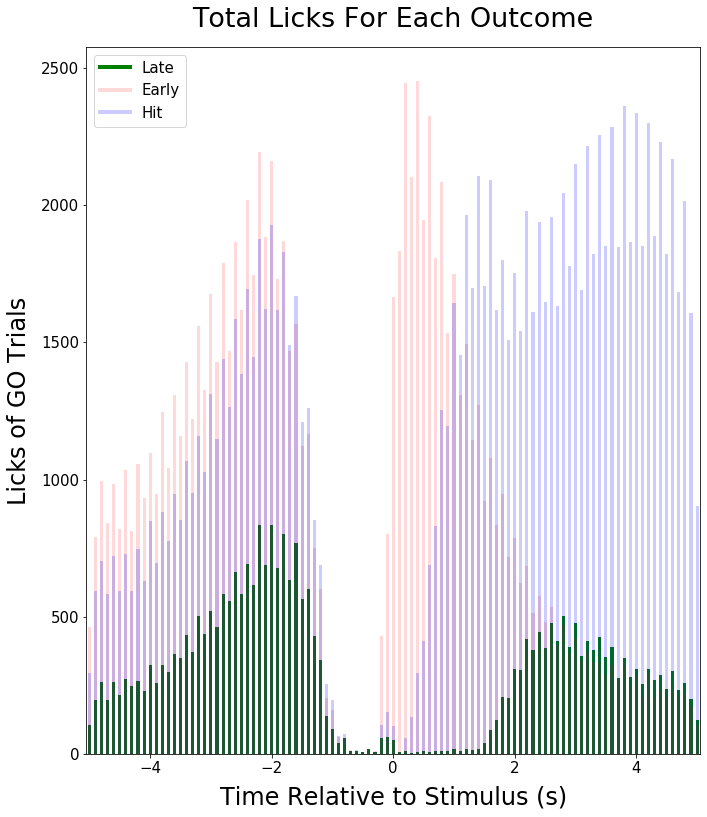

In [155]:
#reploting the above graph to avoid lines of output
custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='red', lw=4,alpha=0.15),
                Line2D([0], [0], color='blue', lw=4,alpha=0.2)]
plot_colors=['green','red','blue']
alpha=[1,0.15,0.2]
plt.figure(figsize=(11, 13))
for i,y,t in zip(list_licks,plot_colors,alpha):
    temp1=[z for z in i.licks_RelativeToTrial]
    temp2=list(itertools.chain.from_iterable(temp1))
    temp2=[round(z,1) for z in temp2]
    u,counts= np.unique(temp2, return_counts=True)
    plt.bar(u,counts,width=0.05,align='center',alpha=t,color=y)
    #ax=sns.barplot(u,counts,color=y,alpha=t)
    plt.xlim(-5.05,5.05)
    plt.ylabel('Licks of GO Trials', size=24,labelpad=10)
    plt.xlabel('Time Relative to Stimulus (s)',size=24,labelpad=10)
    plt.title('Total Licks For Each Outcome',size=27,pad=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(custom_lines,['Late','Early','Hit'],prop={'size': 15})
plt.savefig('Total_Licks_for_Each_Outcome.svg')

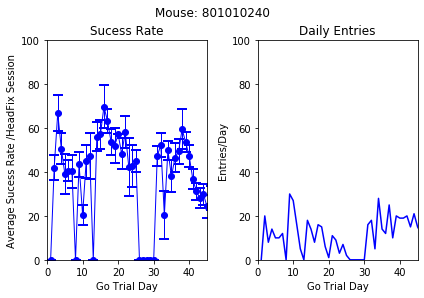

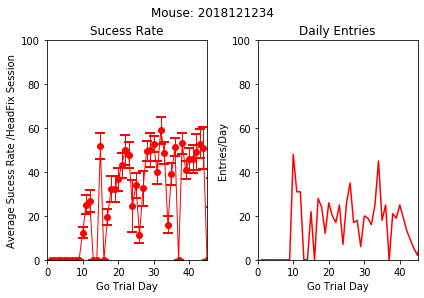

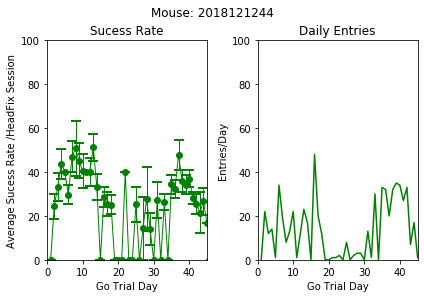

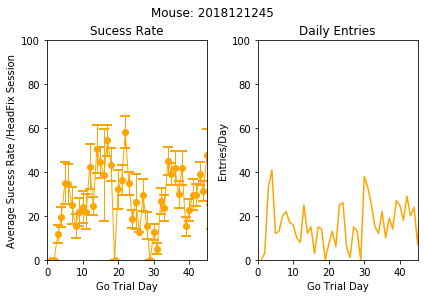

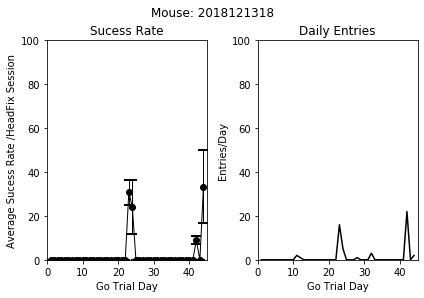

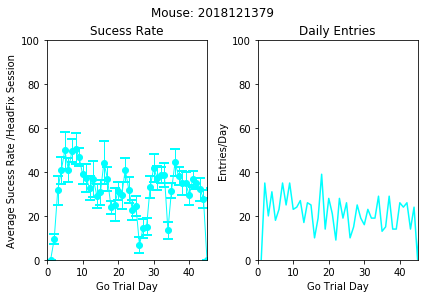

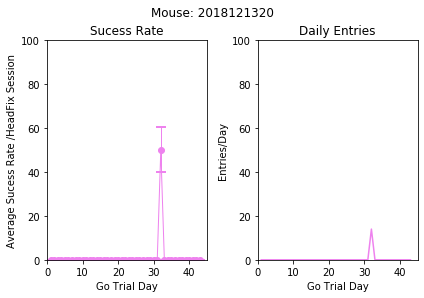

In [40]:
# graphs of all mice: sucess rate (by headfix session) and daily entries
# the corresponding csv files are also saved
df_801010240=mouse_fix_stats("801010240",'blue')
df_2018121234=mouse_fix_stats("2018121234",'red')
df_2018121244=mouse_fix_stats("2018121244",'green')
df_2018121245=mouse_fix_stats("2018121245",'orange')
df_2018121318=mouse_fix_stats("2018121318",'black')
df_2018121379=mouse_fix_stats("2018121379",'cyan')
df_2018121320=mouse_fix_stats("2018121320",'violet')

In [41]:
#a list of dictionaries containning the the noheadfix session of by mouse
#go session started on 2019-10-23
#however no non-fix sessions were found for 2019-10-23, 2019-10-24
#cage is cagex
#Should start on 2019-10-26
#End date to look at is 2019-12-08
#takes some time as the query is ran
#when compelted: all process are complete will be printed 
#after running use the cell below to graph each mouse 
list_dic_df_no=Head_nofix_range()

Cage data to convert to text_logcagex
Enter start date to look at (YYYY-MM-DD):2019-10-26
Enter end date to look at(YYYY-MM-DD):2019-12-08
Succesfully conected to local database using default credentials
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-26 Headfix Session df created
Succesfully conected to local database using default credentials
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-27 Headfix Session df created
Succesfully conected to local database using default credentials
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-28 Headfix Session df created
Succesfully conected to local database using default credentials
All Headfix sessions have one VideoStart and VideoEnd event
2019-10-29 Headfix Session df created
Succesfully conected to local database using default credentials
No additional VideoEnd found after headfix:check+ 17433
Ignoring all events after 17433
All Headfix sessions have one VideoStart and VideoEnd ev

No additional VideoEnd found after headfix:check+ 5409
Ignoring all events after 5409
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-05 Headfix Session df created
Succesfully conected to local database using default credentials
No additional VideoEnd found after headfix:check+ 11872
Ignoring all events after 11872
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-06 Headfix Session df created
Succesfully conected to local database using default credentials
No additional VideoEnd found after headfix:check+ 7628
Ignoring all events after 7628
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-07 Headfix Session df created
Succesfully conected to local database using default credentials
All Headfix sessions have one VideoStart and VideoEnd event
2019-12-08 Headfix Session df created
All processes completed


In [42]:
#Caluclating the Sucess rate per mice Total_Sucess_trial_number/Total_trial_number 
# usign the df master_list3 generated in the previous cell 
#asks users to enter range of dates to delete r1 and r2
# sums the dates from r1 and r2 to create dates range list r3 to delete
#delete 10-22 ----10-25 (nothing logged for no fix trials)
#delete 12-09 ----12-22
df_trial_sucess_rate= (master_list3.groupby(['Tag', pd.Grouper(key='Session_Start_Time',freq='1D')])).sum()
df_trial_sucess_rate['Sucess_rate']=df_trial_sucess_rate['Sucess_count']/df_trial_sucess_rate['Number_of_Trials']*100
df_trial_sucess_rate=df_trial_sucess_rate.reset_index()
r1=date_range()
r2=date_range()
r3=r1+r2
index_delete=[]
for i in r3:
    for z in df_trial_sucess_rate[df_trial_sucess_rate.Session_Start_Time==i].index:
        index_delete.append(z)
df_trial_sucess_rate=df_trial_sucess_rate.drop(index_delete)
df_trial_sucess_rate=df_trial_sucess_rate.reset_index()
df_fixed_sucess_mean=list(df_trial_sucess_rate.groupby([pd.Grouper(key='Session_Start_Time',freq='1D')]).mean().Sucess_rate)
df_fixed_sucess_sem=list(df_trial_sucess_rate.groupby([pd.Grouper(key='Session_Start_Time',freq='1D')]).sem().Sucess_rate)
#save for analysis 
df_trial_sucess_rate.to_csv('df_sucess_fix.csv')

Enter start date to look at (YYYY-MM-DD):2019-10-22
Enter end date to look at(YYYY-MM-DD):2019-10-25
Enter start date to look at (YYYY-MM-DD):2019-12-09
Enter end date to look at(YYYY-MM-DD):2019-12-22


In [43]:
#Creating no fixed df for comparison with fixed sucess rate
#a df of trial no sucess rate is creating 
# sucess rate here is per trial 
master_list_nofix=[]
for i in tags:
    templist=[]
    print(i)
    count=0
    for z in list_dic_df_no:
        count+=1
        try:
            templist.append(z[str(i)])
            print(count)
        except Exception as e:
            print('error at'+str(count)+', no event for tag'+str(i))
    templist=pd.concat(templist)
    master_list_nofix.append(templist)
master_list_nofix=pd.concat(master_list_nofix)
#aster_list2=master_list_nofix[master_list_nofix.Number_of_Trials !=0]
Sucess_count=[i.count(2) for i in master_list_nofix.Trial_outcomes]
master_list_nofix['Sucess_count']=Sucess_count
master_list_nofix= master_list_nofix[['Tag','Session_Start_Time','Number_of_Trials','Sucess_count']]
df_trial_sucess_rate2= (master_list_nofix.groupby(['Tag', pd.Grouper(key='Session_Start_Time',freq='1D')])).sum()
df_trial_sucess_rate2['Sucess_rate']=df_trial_sucess_rate2['Sucess_count']/df_trial_sucess_rate2['Number_of_Trials']*100
df_trial_sucess_rate2=df_trial_sucess_rate2.reset_index()
df_nofixed_sucess_mean=list(df_trial_sucess_rate2.groupby([pd.Grouper(key='Session_Start_Time',freq='1D')]).mean().Sucess_rate)
df_nofixed_sucess_sem=list(df_trial_sucess_rate2.groupby([pd.Grouper(key='Session_Start_Time',freq='1D')]).sem().Sucess_rate)
#saved for stastical compasisons
df_trial_sucess_rate2.to_csv('df_success_rate_nofix.csv')

801010240
error at1, no event for tag801010240
error at2, no event for tag801010240
3
error at4, no event for tag801010240
5
6
7
8
error at9, no event for tag801010240
10
11
12
13
14
error at15, no event for tag801010240
error at16, no event for tag801010240
17
18
error at19, no event for tag801010240
error at20, no event for tag801010240
21
error at22, no event for tag801010240
error at23, no event for tag801010240
error at24, no event for tag801010240
error at25, no event for tag801010240
error at26, no event for tag801010240
27
28
error at29, no event for tag801010240
30
error at31, no event for tag801010240
32
33
34
35
36
error at37, no event for tag801010240
38
39
error at40, no event for tag801010240
error at41, no event for tag801010240
error at42, no event for tag801010240
error at43, no event for tag801010240
44
2018121234
error at1, no event for tag2018121234
error at2, no event for tag2018121234
error at3, no event for tag2018121234
error at4, no event for tag2018121234
erro

Text(0.5, 1.0, 'Fix-NoFix Trial Success Rate')

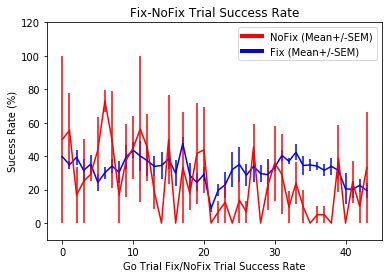

In [44]:
#Fix no fix Trial Success rate
#compared between the period of 2019-10-26 ----2019-12-08
#plots out the graph
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
plt.errorbar(x=range(len(df_fixed_sucess_mean)),y=df_fixed_sucess_mean,yerr=df_fixed_sucess_sem,color='blue')
plt.errorbar(x=range(len(df_nofixed_sucess_mean)),y=df_nofixed_sucess_mean,yerr=df_nofixed_sucess_sem,color='red')
plt.xlabel('Go Trial Fix/NoFix Trial Success Rate')
plt.ylabel('Sucess Rate (%)')
plt.ylim(-10,120)
plt.legend(custom_lines,['NoFix (Mean+/-SEM)','Fix (Mean+/-SEM)'])
plt.title('Fix-NoFix Trial Success Rate')

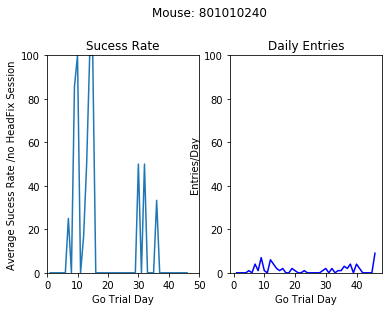

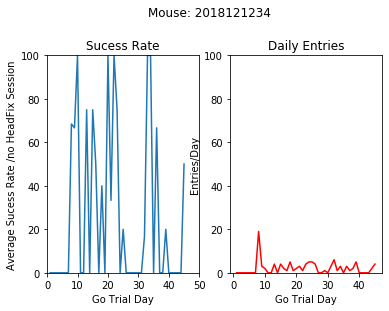

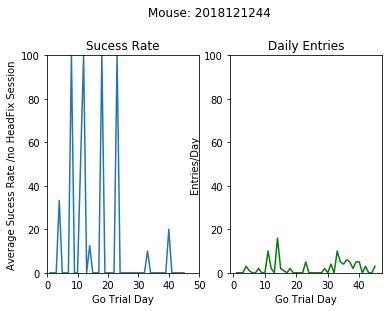

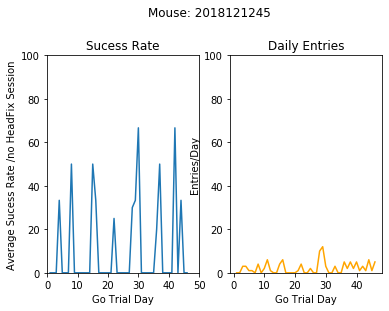

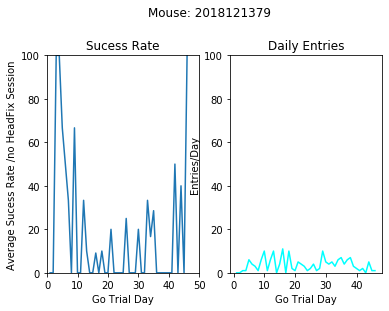

In [45]:
# graphs of all mice: sucess rate (per headfix session) and daily entries
# the corresponding csv files are also saved
df_801010240=mouse_nofix_stats("801010240",'blue')
df_2018121234=mouse_nofix_stats("2018121234",'red')
df_2018121244=mouse_nofix_stats("2018121244",'green')
df_2018121245=mouse_nofix_stats("2018121245",'orange')
#df_2018121318=mouse_nofix_stats("2018121318",'black')
df_2018121379=mouse_nofix_stats("2018121379",'cyan')
#df_2018121320=mouse_nofix_stats("2018121320",'violet')
#no events for mouse 2018121320

#The blow cells just uses the csv files created from mouse_fix_stats/mouse_nofix_stats

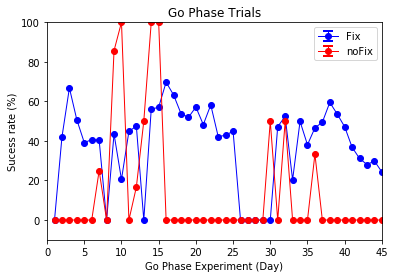

In [46]:
#### average success rate per headfix sesssion (proportion of sucessful trials per headfix session)/N_headfix session 
#### different than paper ( successful trials/total trials)
a='stats2019-10-22_2019-11-27.csv'
list_tag_analyze=["801010240","2018121234","2018121244","2018121379","2018121245"]
files=[]
for i in os.listdir():
    if i[-30:] == a:
        files.append(i)
Stats_Sucess=[]
Stats_Entries=[]
for i in files: 
    if i[:9] in list_tag_analyze:
        df=pd.read_csv(i)
        df=df.drop('Unnamed: 0',axis=1)
        df1=df[['Tag','GO_day','Type','Percent_Sucess_Mean']]
        df_entry=df[['Tag','GO_day','Type','Entries']]
        Stats_Sucess.append(df1)
        Stats_Entries.append(df_entry)
    else:
        pass
df_Sucess=pd.concat(Stats_Sucess)
df_Entries=pd.concat(Stats_Entries)
###Fix data
fix_mean=df_Sucess[df_Sucess['Type']=='Fix'].groupby('GO_day')['Percent_Sucess_Mean'].mean()
fix_sem=df_Sucess[df_Sucess['Type']=='Fix'].groupby('GO_day')['Percent_Sucess_Mean'].sem()
plt.errorbar(x=fix_mean.index,y=fix_mean,yerr=fix_sem,fmt='-o',markersize='6',
             capthick=2, capsize=5, ecolor='blue', color= 'blue',linewidth=1)
###no fix data
nofix_mean=df_Sucess[df_Sucess['Type']=='noFix'].groupby('GO_day')['Percent_Sucess_Mean'].mean()
nofix_sem=df_Sucess[df_Sucess['Type']=='noFix'].groupby('GO_day')['Percent_Sucess_Mean'].sem()
plt.errorbar(x=nofix_mean.index,y=nofix_mean,yerr=nofix_sem,fmt='-o',markersize='6',
             capthick=2, capsize=5, ecolor='red', color= 'red',linewidth=1)
plt.ylabel('Sucess rate (%)')
plt.ylim([-10,100])
plt.xlabel('Go Phase Experiment (Day)')
plt.xlim([0,45])
plt.title('Go Phase Trials')
#plt.hlines(y=0,xmin=-10,xmax=1000,color='black',linestyles='solid')
plt.legend(['Fix', 'noFix'])

In [55]:
# dfs for containing the total number of licks
#the lick by tag and date for total licks
#Please note that the total number of licks does not equal licks the sum of headfix and non-headfix sessions.
#This is because some sessions were deleted as described in the fucntion Fix_event() and noFix_event()
df_total_lick=df_licks.groupby(['Tag',pd.Grouper(key='Timestamp',freq='D')]).sum()
df_licks.groupby(['Tag',pd.Grouper(key='Timestamp',freq='D')]).sum().to_csv('Total_Licks.csv')
df_total_lick=df_total_lick.reset_index()
df_total_lick=df_total_lick.rename(columns={'Timestamp':'Session_Start_Time'})
#the lick by tag and date in head fixed mice (used the data generated from master_list, see about cells)
master_list['N_licks']= [len(i) for i in master_list.lick_Timestamp]
df_licks_fix=master_list[['Tag','Session_Start_Time','N_licks']]
df_licks_fix=df_licks_fix.groupby (['Tag',pd.Grouper(key='Session_Start_Time',freq='D')]).sum()
df_licks_fix.reset_index().to_csv('Headfix_licks.csv')
df_licks_fix=df_licks_fix.reset_index()
# the lick by tag and date in no fixed mice (used the data generated from master_list_nofix, see about cells)
master_list_nofix=[]
for i in tags:
    templist=[]
    print(i)
    count=0
    for z in list_dic_df_no:
        count+=1
        try:
            templist.append(z[str(i)])
            print(count)
        except Exception as e:
            print('error at'+str(count)+', no event for tag'+str(i))
    templist=pd.concat(templist)
    master_list_nofix.append(templist)
master_list_nofix=pd.concat(master_list_nofix)
master_list_nofix['N_licks']= [len(i) for i in master_list_nofix.lick_Timestamp]
df_licks_nofix=master_list_nofix[['Tag','Session_Start_Time','N_licks']]
df_licks_nofix=df_licks_nofix.groupby (['Tag',pd.Grouper(key='Session_Start_Time',freq='D')]).sum()
df_licks_nofix.reset_index().to_csv('Headnofix_licks.csv')
df_licks_nofix=df_licks_nofix.reset_index()
df_lickdf= pd.merge(df_licks_nofix,df_licks_fix,on=['Tag','Session_Start_Time'],how="outer")
df_lickdf=pd.merge(df_lickdf,df_total_lick,on=['Tag','Session_Start_Time'],how="outer")
df_lickdf=df_lickdf.rename(columns={'N_licks_x':'noFix','N_licks_y':'Fix','lick_Daily':'Fix_and_noFix'})
df_lickdf.groupby(pd.Grouper(key='Session_Start_Time')).sum().to_csv('Number_lick_by_tag.csv')
#save df for external use
df_lickdf.to_csv('Number_licks_TagandDate.csv')

801010240
error at1, no event for tag801010240
error at2, no event for tag801010240
3
error at4, no event for tag801010240
5
6
7
8
error at9, no event for tag801010240
10
11
12
13
14
error at15, no event for tag801010240
error at16, no event for tag801010240
17
18
error at19, no event for tag801010240
error at20, no event for tag801010240
21
error at22, no event for tag801010240
error at23, no event for tag801010240
error at24, no event for tag801010240
error at25, no event for tag801010240
error at26, no event for tag801010240
27
28
error at29, no event for tag801010240
30
error at31, no event for tag801010240
32
33
34
35
36
error at37, no event for tag801010240
38
39
error at40, no event for tag801010240
error at41, no event for tag801010240
error at42, no event for tag801010240
error at43, no event for tag801010240
44
2018121234
error at1, no event for tag2018121234
error at2, no event for tag2018121234
error at3, no event for tag2018121234
error at4, no event for tag2018121234
erro

In [57]:
#reads saved csv files to create summary table of the mice 
# Data read from 4 csv files 
df_head=pd.read_csv('Total_headfixes_pertag.csv')
df_head=df_head.drop(columns=['Unnamed: 0'])
df_headfixtime=pd.read_csv('HFX_duration_permice.csv')
df_sucess_fix= pd.read_csv('df_sucess_fix.csv')
df_sucess_nofix=pd.read_csv('df_success_rate_nofix.csv')
pd.set_option('display.max_rows', 500)
# data mungling to form the summary tables
df_head=pd.read_csv('Total_headfixes_pertag.csv')
df_head=df_head.drop(columns=['Unnamed: 0'])
df_headfixtime=pd.read_csv('HFX_duration_permice.csv')
df_sucess_fix= pd.read_csv('df_sucess_fix.csv')
df_sucess_nofix=pd.read_csv('df_success_rate_nofix.csv')
pd.set_option('display.max_rows', 500)
df_Final=df_head.groupby(['Tag']).sum()
df_Final.rename(columns={'Fix_Daily':'Total head-fixes'})
dic_headfixtime=[]
for i in df_Final.index:
    dic_headfixtime.append(df_headfixtime[str(i)].sum()/3600)
df_Final['Total hours Head fixed']= dic_headfixtime
df_Final=df_Final.rename(columns={'Fix_Daily':'Total Head-Fixes'})
df_head['Timestamp']=pd.to_datetime(df_headfixtime['Session_Start_Time'])
df_Final['Head-fixes/day']= df_head.groupby(['Tag']).mean()
dic_headfixtime_minute=[]
for i in df_Final.index:
    dic_headfixtime_minute.append(df_headfixtime.mean(axis=0)[str(i)]/60)
df_Final['Minutes head-fixesd/day']=dic_headfixtime_minute
df_last_5sucess=df_sucess_fix.loc[df_sucess_fix.Session_Start_Time>'2019-12-03']
df_last_5sucess_nofix=df_sucess_nofix.loc[df_sucess_nofix.Session_Start_Time>'2019-12-03']
df_last5=pd.concat([df_last_5sucess,df_last_5sucess_nofix])
df_last5.Session_Start_Time=pd.to_datetime(df_last5.Session_Start_Time)
list_sucess=[]
for i in df_Final.index:
    list_sucess.append(df_last5.groupby(['Tag']).mean().Sucess_rate[i])
df_Final['Sucess_rate_GO_Trials_last_5days']=list_sucess
df_Final['Group']=6
list_headfix_days_len=[]
for i in df_Final.index:
        list_headfix_days_len.append(df_headfixtime.count(0)[str(i)])
df_Final['Days_with_head-fixation']=list_headfix_days_len
list_HFPdays=[]
for i in df_Final.index:
    temp=max(df_headfixtime[str(i)][df_headfixtime[str(i)].notnull()== True].index+1)
    list_HFPdays.append(temp)
df_Final['Days_Under_headfix_protocol']=list_HFPdays
df_Final=df_Final[['Group','Days_Under_headfix_protocol', 'Days_with_head-fixation',
         'Total Head-Fixes', 'Total hours Head fixed', 'Head-fixes/day',
       'Minutes head-fixesd/day', 'Sucess_rate_GO_Trials_last_5days']]

/alder/apps/jupyter/generic-01/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



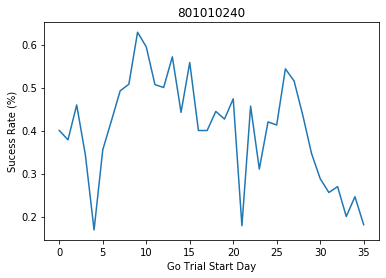

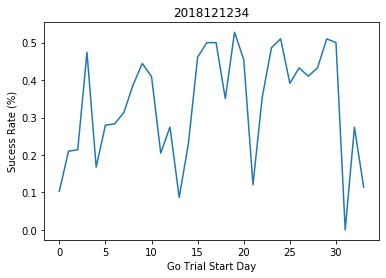

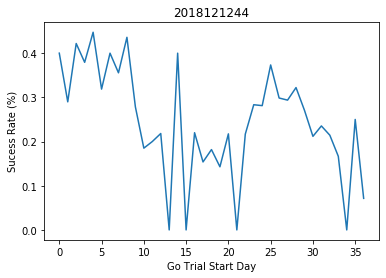

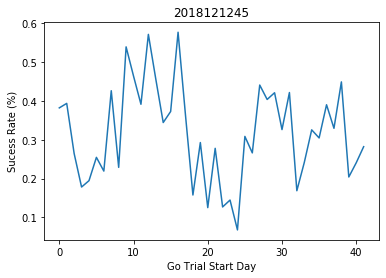

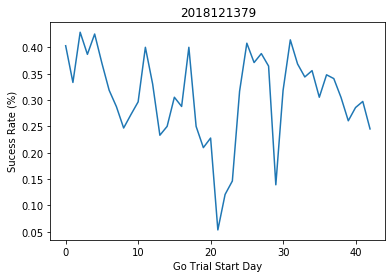

In [58]:
#Used to figure out which dates to use as last 5 days sucess rate
#the last 5 days before a major decrease/ sharpe drope in sucess rate is used 
#ploting out the graphs of individual mouse success rate for the trials 
#used to include the last 5 days of the trials 
df_success=df_sucess_fix
df_success.Session_Start_Time=pd.to_datetime(df_success.Session_Start_Time)
df_success=df_success.groupby(['Tag',pd.Grouper(key='Session_Start_Time',freq='D')]).sum()
df_success=df_success.drop(columns=['Sucess_rate','Unnamed: 0','index'])
df_success['Success_rate']=df_success['Sucess_count']/df_success['Number_of_Trials']
df_success=df_success.reset_index()
list_tag=[i for i in df_success.Tag.unique()]
for i in list_tag:
    fig1=plt.figure()
    x=range(len(df_success[df_success.Tag==i].Success_rate))
    y=df_success[df_success.Tag==i].Success_rate
    plt.plot(x,y)
    plt.title(str(i))
    plt.xlabel('Go Trial Start Day')
    plt.ylabel('Sucess Rate (%)')

Determined last 5 days to use in the table from the above graphs 

801010240-> Day 22-27 

2018121234-> Day 25-30 

2018121244-> Day 29-34

2018121245-> Day 26-31

2018121379-> Day 32-37

In [ ]:
#date range to use for the last 5 days sucess rate 
list_index=[(22,27),(25,30),(23,28),(25,30),(32,37)]

In [ ]:
#last 5 day sucess rate for the summary table and saving the table in csv formate
list_5dsr=[]
list_5dnt=[]
list_5dnst=[]
list_index=[(22,27),(25,30),(23,28),(25,30),(32,37)]
for i,z in zip(list_tag,list_index):
    sucess_rate=df_success[df_success.Tag==i].Success_rate[z[0]:z[1]].mean()
    n_trials=df_success[df_success.Tag==i].Number_of_Trials[z[0]:z[1]].mean()
    ns_trials=df_success[df_success.Tag==i].Sucess_count[z[0]:z[1]].mean()
    list_5dsr.append(sucess_rate*100)
    list_5dnt.append(n_trials)
    list_5dnst.append(ns_trials)
df_Final=df_Final.drop(columns=['Sucess_rate_GO_Trials_last_5days'])
df_Final['Average_Number_of_Trials_last_5days']=list_5dnt
df_Final['Average_Number_of_Sucessful_Trials_last_5days']=list_5dnst
df_Final['Sucess_rate_GO_Trials_last_5days']=list_5dsr
#days in cage change to 71 for mouse 2018121244, mouse was in cage but did nothing
df_Final.at[2018121244, 'Days_Under_headfix_protocol'] = 71
df_Final.to_csv('AHF_Female_table.csv')